In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2])

In [3]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [4]:
# Domain bounds
label = "Regr_disc_Stan"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)

    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    nan_flag = 0  
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [10]:
nan_tune = []

for tune_reps in range(5):
    label = "Regr_disc_tanh_tune"+str(tune_reps) 
    max_reps = 10
    max_iter = 500
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []

    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))


    for reps in range(max_reps):
        print(label)

        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        beta_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lr_tune[tune_reps])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
      
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
    savemat(label+'.mat', mdic) 

Regr_disc_tanh_tune0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290442.56 Test MSE 273269.97390847583 Test RE 0.9998249255941304
1 Train Loss 290441.66 Test MSE 273269.10168125335 Test RE 0.9998233299647219
2 Train Loss 290440.75 Test MSE 273268.22929925186 Test RE 0.9998217340496173
3 Train Loss 290439.8 Test MSE 273267.3567414706 Test RE 0.9998201378103977
4 Train Loss 290438.88 Test MSE 273266.48401984415 Test RE 0.9998185412688938
5 Train Loss 290437.97 Test MSE 273265.61109066446 Test RE 0.999816944345145
6 Train Loss 290437.06 Test MSE 273264.73799088155 Test RE 0.9998153471067459
7 Train Loss 290436.12 Test MSE 2732

187 Train Loss 290263.62 Test MSE 273100.498755257 Test RE 0.9995148443956045
188 Train Loss 290262.66 Test MSE 273099.54589732346 Test RE 0.999513100721601
189 Train Loss 290261.66 Test MSE 273098.5924411225 Test RE 0.9995113559497589
190 Train Loss 290260.66 Test MSE 273097.63839472405 Test RE 0.9995096100948395
191 Train Loss 290259.62 Test MSE 273096.68373631395 Test RE 0.9995078631169186
192 Train Loss 290258.6 Test MSE 273095.7285051654 Test RE 0.999506115087858
193 Train Loss 290257.6 Test MSE 273094.77267406613 Test RE 0.9995043659578552
194 Train Loss 290256.6 Test MSE 273093.8162061342 Test RE 0.9995026156594121
195 Train Loss 290255.6 Test MSE 273092.85916770814 Test RE 0.9995008643139195
196 Train Loss 290254.56 Test MSE 273091.9015082002 Test RE 0.9994991118287979
197 Train Loss 290253.56 Test MSE 273090.94322849554 Test RE 0.9994973582056611
198 Train Loss 290252.53 Test MSE 273089.98437397776 Test RE 0.9994956035275538
199 Train Loss 290251.53 Test MSE 273089.02487944654

393 Train Loss 290040.6 Test MSE 272889.292447519 Test RE 0.9991282748513608
394 Train Loss 290039.4 Test MSE 272888.18308154144 Test RE 0.999126243991095
395 Train Loss 290038.25 Test MSE 272887.0728381157 Test RE 0.999124211520397
396 Train Loss 290037.06 Test MSE 272885.96169718617 Test RE 0.9991221774025407
397 Train Loss 290035.9 Test MSE 272884.84964796255 Test RE 0.9991201416177632
398 Train Loss 290034.72 Test MSE 272883.7366830145 Test RE 0.9991181041524517
399 Train Loss 290033.56 Test MSE 272882.6227830435 Test RE 0.9991160649712667
400 Train Loss 290032.38 Test MSE 272881.50801597006 Test RE 0.9991140241985385
401 Train Loss 290031.22 Test MSE 272880.3923655748 Test RE 0.9991119818045642
402 Train Loss 290030.03 Test MSE 272879.2757855563 Test RE 0.999109937704571
403 Train Loss 290028.8 Test MSE 272878.1583130476 Test RE 0.9991078919665275
404 Train Loss 290027.62 Test MSE 272877.039939201 Test RE 0.9991058445742259
405 Train Loss 290026.47 Test MSE 272875.92065544246 Test

497 Train Loss 289913.5 Test MSE 272769.0055891081 Test RE 0.9989080477275194
498 Train Loss 289912.22 Test MSE 272767.80017408315 Test RE 0.998905840548414
499 Train Loss 289910.94 Test MSE 272766.5938311857 Test RE 0.9989036316654415
Training time: 1.01
Regr_disc_tanh_tune0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 292828.53 Test MSE 273426.8126375735 Test RE 1.0001118008315761
1 Train Loss 292827.47 Test MSE 273425.8637679692 Test RE 1.0001100654924135
2 Train Loss 292826.47 Test MSE 273424.9149921869 Test RE 1.000108330321827
3 Train Loss 292825.4 Test MSE 273423.9662683242 Test RE 1.000106595243183
4 Train Loss 29282

99 Train Loss 292726.2 Test MSE 273333.0077590958 Test RE 0.9999402313121948
100 Train Loss 292725.2 Test MSE 273332.0573408339 Test RE 0.9999384928425333
101 Train Loss 292724.12 Test MSE 273331.1067628422 Test RE 0.9999367540776775
102 Train Loss 292723.1 Test MSE 273330.15599975106 Test RE 0.9999350149712191
103 Train Loss 292722.03 Test MSE 273329.2050745604 Test RE 0.9999332755652279
104 Train Loss 292721.0 Test MSE 273328.25396232936 Test RE 0.9999315358140811
105 Train Loss 292719.97 Test MSE 273327.30265875795 Test RE 0.9999297957099114
106 Train Loss 292718.94 Test MSE 273326.35117406317 Test RE 0.9999280552714057
107 Train Loss 292717.88 Test MSE 273325.3995221422 Test RE 0.9999263145239826
108 Train Loss 292716.88 Test MSE 273324.44766624656 Test RE 0.9999245734004206
109 Train Loss 292715.84 Test MSE 273323.49560502736 Test RE 0.9999228318982509
110 Train Loss 292714.78 Test MSE 273322.54335692065 Test RE 0.9999210900511935
111 Train Loss 292713.75 Test MSE 273321.590902540

298 Train Loss 292513.56 Test MSE 273138.0515444735 Test RE 0.9995835613701773
299 Train Loss 292512.47 Test MSE 273137.034452574 Test RE 0.9995817002796337
300 Train Loss 292511.34 Test MSE 273136.01693013124 Test RE 0.9995798383978083
301 Train Loss 292510.22 Test MSE 273134.9989683146 Test RE 0.9995779757085379
302 Train Loss 292509.12 Test MSE 273133.9805794364 Test RE 0.9995761122343471
303 Train Loss 292508.0 Test MSE 273132.96177179634 Test RE 0.999574247990419
304 Train Loss 292506.88 Test MSE 273131.9424918931 Test RE 0.999572382878851
305 Train Loss 292505.78 Test MSE 273130.92282369576 Test RE 0.9995705170532876
306 Train Loss 292504.7 Test MSE 273129.902698093 Test RE 0.9995686503872618
307 Train Loss 292503.56 Test MSE 273128.8821145657 Test RE 0.9995667828798196
308 Train Loss 292502.47 Test MSE 273127.86115112604 Test RE 0.9995649146737065
309 Train Loss 292501.34 Test MSE 273126.8397326591 Test RE 0.9995630456314695
310 Train Loss 292500.22 Test MSE 273125.81787566247 T

4 Train Loss 279534.22 Test MSE 273310.8365134775 Test RE 0.9998996757088905
5 Train Loss 279533.5 Test MSE 273310.13455106074 Test RE 0.9998983916536139
6 Train Loss 279532.8 Test MSE 273309.4324464715 Test RE 0.9998971073366205
7 Train Loss 279532.06 Test MSE 273308.7301987801 Test RE 0.9998958227562095
8 Train Loss 279531.38 Test MSE 273308.0278108866 Test RE 0.9998945379176838
9 Train Loss 279530.66 Test MSE 273307.32529155473 Test RE 0.9998932528370739
10 Train Loss 279529.94 Test MSE 273306.62260834477 Test RE 0.9998919674550384
11 Train Loss 279529.2 Test MSE 273305.9197754761 Test RE 0.9998906817975872
12 Train Loss 279528.5 Test MSE 273305.2167718415 Test RE 0.9998893958261088
13 Train Loss 279527.78 Test MSE 273304.513628404 Test RE 0.9998881095972411
14 Train Loss 279527.06 Test MSE 273303.8103287277 Test RE 0.9998868230809171
15 Train Loss 279526.34 Test MSE 273303.10684325657 Test RE 0.9998855362230709
16 Train Loss 279525.62 Test MSE 273302.4032197843 Test RE 0.9998842491

210 Train Loss 279380.28 Test MSE 273159.847111588 Test RE 0.9996234424044546
211 Train Loss 279379.47 Test MSE 273159.0694722381 Test RE 0.9996220195249839
212 Train Loss 279378.7 Test MSE 273158.29129706824 Test RE 0.9996205956630743
213 Train Loss 279377.9 Test MSE 273157.51257443737 Test RE 0.9996191707974199
214 Train Loss 279377.06 Test MSE 273156.7333389645 Test RE 0.9996177449913612
215 Train Loss 279376.3 Test MSE 273155.953577134 Test RE 0.999616318220164
216 Train Loss 279375.5 Test MSE 273155.1732684828 Test RE 0.9996148904463817
217 Train Loss 279374.72 Test MSE 273154.3924494163 Test RE 0.9996134617366231
218 Train Loss 279373.9 Test MSE 273153.6110826748 Test RE 0.9996120320227072
219 Train Loss 279373.1 Test MSE 273152.82918033557 Test RE 0.9996106013267295
220 Train Loss 279372.3 Test MSE 273152.04674715915 Test RE 0.9996091696573953
221 Train Loss 279371.53 Test MSE 273151.2637601835 Test RE 0.9996077369726858
222 Train Loss 279370.72 Test MSE 273150.4802597239 Test R

314 Train Loss 279294.75 Test MSE 273075.94040180725 Test RE 0.9994699030813378
315 Train Loss 279293.9 Test MSE 273075.1018926804 Test RE 0.9994683685900937
316 Train Loss 279293.06 Test MSE 273074.26277898235 Test RE 0.9994668329901117
317 Train Loss 279292.16 Test MSE 273073.4230095809 Test RE 0.9994652961878131
318 Train Loss 279291.34 Test MSE 273072.5825662988 Test RE 0.999463758149928
319 Train Loss 279290.5 Test MSE 273071.74151022924 Test RE 0.9994622189882526
320 Train Loss 279289.6 Test MSE 273070.89979554765 Test RE 0.9994606786189213
321 Train Loss 279288.75 Test MSE 273070.057440015 Test RE 0.999459137074432
322 Train Loss 279287.9 Test MSE 273069.21444545774 Test RE 0.9994575943581214
323 Train Loss 279287.03 Test MSE 273068.3707908262 Test RE 0.9994560504314626
324 Train Loss 279286.2 Test MSE 273067.52651928196 Test RE 0.9994545053734375
325 Train Loss 279285.3 Test MSE 273066.6815945935 Test RE 0.9994529591177356
326 Train Loss 279284.47 Test MSE 273065.8360026325 Tes

419 Train Loss 279201.34 Test MSE 272984.2248145999 Test RE 0.9993020474528681
420 Train Loss 279200.38 Test MSE 272983.3138607559 Test RE 0.9993003801059698
421 Train Loss 279199.47 Test MSE 272982.4021596019 Test RE 0.9992987113884622
422 Train Loss 279198.53 Test MSE 272981.4897216477 Test RE 0.9992970413195738
423 Train Loss 279197.6 Test MSE 272980.5765438937 Test RE 0.9992953698938081
424 Train Loss 279196.7 Test MSE 272979.6626003294 Test RE 0.9992936970635498
425 Train Loss 279195.75 Test MSE 272978.747934286 Test RE 0.9992920229081039
426 Train Loss 279194.8 Test MSE 272977.832467478 Test RE 0.9992903472841727
427 Train Loss 279193.88 Test MSE 272976.9162834012 Test RE 0.9992886703445762
428 Train Loss 279192.94 Test MSE 272975.99936194025 Test RE 0.9992869920524896
429 Train Loss 279192.0 Test MSE 272975.0816885435 Test RE 0.9992853123812707
430 Train Loss 279191.06 Test MSE 272974.16325623036 Test RE 0.9992836313181359
431 Train Loss 279190.12 Test MSE 272973.24406177097 Tes

116 Train Loss 305537.6 Test MSE 273319.7089058308 Test RE 0.9999159052707203
117 Train Loss 305536.47 Test MSE 273318.70262210554 Test RE 0.9999140645691619
118 Train Loss 305535.38 Test MSE 273317.69595840666 Test RE 0.9999122231691628
119 Train Loss 305534.22 Test MSE 273316.6889079414 Test RE 0.999910381058293
120 Train Loss 305533.1 Test MSE 273315.6814675603 Test RE 0.9999085382307883
121 Train Loss 305531.97 Test MSE 273314.673614553 Test RE 0.9999066946451024
122 Train Loss 305530.84 Test MSE 273313.66537848115 Test RE 0.9999048503553052
123 Train Loss 305529.72 Test MSE 273312.656712452 Test RE 0.9999030052756162
124 Train Loss 305528.6 Test MSE 273311.6476420212 Test RE 0.9999011594527778
125 Train Loss 305527.47 Test MSE 273310.6381709665 Test RE 0.9998993128936962
126 Train Loss 305526.34 Test MSE 273309.6282869668 Test RE 0.9998974655758294
127 Train Loss 305525.22 Test MSE 273308.6179699145 Test RE 0.9998956174623916
128 Train Loss 305524.06 Test MSE 273307.60724111565 Te

220 Train Loss 305417.8 Test MSE 273212.5773094218 Test RE 0.9997199203438496
221 Train Loss 305416.62 Test MSE 273211.51954355347 Test RE 0.9997179850913741
222 Train Loss 305415.4 Test MSE 273210.461176857 Test RE 0.9997160487358945
223 Train Loss 305414.25 Test MSE 273209.4022394104 Test RE 0.9997141113324343
224 Train Loss 305413.06 Test MSE 273208.3426963621 Test RE 0.9997121728172234
225 Train Loss 305411.9 Test MSE 273207.28258408024 Test RE 0.9997102332567942
226 Train Loss 305410.7 Test MSE 273206.2218515944 Test RE 0.999708292557886
227 Train Loss 305409.53 Test MSE 273205.16054318554 Test RE 0.9997063508015076
228 Train Loss 305408.3 Test MSE 273204.0986352336 Test RE 0.9997044079444384
229 Train Loss 305407.16 Test MSE 273203.03610530146 Test RE 0.9997024639456207
230 Train Loss 305405.97 Test MSE 273201.97300818644 Test RE 0.9997005189053046
231 Train Loss 305404.75 Test MSE 273200.90928462305 Test RE 0.999698572715053
232 Train Loss 305403.56 Test MSE 273199.8449474373 Te

325 Train Loss 305289.72 Test MSE 273097.9845249701 Test RE 0.9995102434954057
326 Train Loss 305288.44 Test MSE 273096.8559124193 Test RE 0.999508178190946
327 Train Loss 305287.2 Test MSE 273095.72656154836 Test RE 0.9995061115311251
328 Train Loss 305285.94 Test MSE 273094.5964566826 Test RE 0.9995040434872514
329 Train Loss 305284.66 Test MSE 273093.4656032613 Test RE 0.9995019740692694
330 Train Loss 305283.4 Test MSE 273092.33397239994 Test RE 0.9994999032243135
331 Train Loss 305282.16 Test MSE 273091.2016000132 Test RE 0.9994978310180971
332 Train Loss 305280.88 Test MSE 273090.06847050076 Test RE 0.9994957574220635
333 Train Loss 305279.6 Test MSE 273088.93455425097 Test RE 0.9994936823820159
334 Train Loss 305278.3 Test MSE 273087.7999063325 Test RE 0.9994916059987194
335 Train Loss 305277.06 Test MSE 273086.66448014707 Test RE 0.9994895281868921
336 Train Loss 305275.78 Test MSE 273085.52823814563 Test RE 0.9994874488778103
337 Train Loss 305274.5 Test MSE 273084.39125737187

430 Train Loss 305152.44 Test MSE 272975.1286857933 Test RE 0.9992853984031507
431 Train Loss 305151.06 Test MSE 272973.9143121096 Test RE 0.9992831756599181
432 Train Loss 305149.72 Test MSE 272972.6990517675 Test RE 0.9992809512888303
433 Train Loss 305148.34 Test MSE 272971.4829146823 Test RE 0.9992787253080248
434 Train Loss 305147.0 Test MSE 272970.26592223975 Test RE 0.9992764977566351
435 Train Loss 305145.62 Test MSE 272969.0480075825 Test RE 0.9992742685122766
436 Train Loss 305144.28 Test MSE 272967.8292659702 Test RE 0.9992720377492992
437 Train Loss 305142.88 Test MSE 272966.60958313884 Test RE 0.9992698052585453
438 Train Loss 305141.56 Test MSE 272965.38907833665 Test RE 0.999267571258275
439 Train Loss 305140.16 Test MSE 272964.1676804225 Test RE 0.9992653356182608
440 Train Loss 305138.84 Test MSE 272962.9453774934 Test RE 0.9992630983167055
441 Train Loss 305137.44 Test MSE 272961.72219668044 Test RE 0.9992608594032577
442 Train Loss 305136.1 Test MSE 272960.4981181153

31 Train Loss 258044.33 Test MSE 273027.64873053477 Test RE 0.9993815243578082
32 Train Loss 258043.17 Test MSE 273026.48709455103 Test RE 0.9993793983482623
33 Train Loss 258042.06 Test MSE 273025.3251657067 Test RE 0.9993772717982027
34 Train Loss 258040.97 Test MSE 273024.16291434807 Test RE 0.9993751446533538
35 Train Loss 258039.84 Test MSE 273023.00038612133 Test RE 0.9993730169972533
36 Train Loss 258038.72 Test MSE 273021.83755660505 Test RE 0.9993708887852023
37 Train Loss 258037.61 Test MSE 273020.67442473123 Test RE 0.9993687600152423
38 Train Loss 258036.48 Test MSE 273019.51099222456 Test RE 0.9993666306905258
39 Train Loss 258035.36 Test MSE 273018.34720918664 Test RE 0.999364500719725
40 Train Loss 258034.27 Test MSE 273017.18314576184 Test RE 0.9993623702312154
41 Train Loss 258033.17 Test MSE 273016.01874798245 Test RE 0.9993602391262204
42 Train Loss 258032.03 Test MSE 273014.85401333845 Test RE 0.9993581074001425
43 Train Loss 258030.9 Test MSE 273013.68893651204 Tes

235 Train Loss 257807.69 Test MSE 272780.74267407734 Test RE 0.9989295387002345
236 Train Loss 257806.44 Test MSE 272779.46713179996 Test RE 0.9989272031644928
237 Train Loss 257805.23 Test MSE 272778.19084035925 Test RE 0.9989248662515572
238 Train Loss 257804.0 Test MSE 272776.9137539023 Test RE 0.9989225278774605
239 Train Loss 257802.78 Test MSE 272775.6359190416 Test RE 0.9989201881275402
240 Train Loss 257801.55 Test MSE 272774.35728318675 Test RE 0.9989178469054932
241 Train Loss 257800.33 Test MSE 272773.0778680785 Test RE 0.9989155042511167
242 Train Loss 257799.1 Test MSE 272771.79770249274 Test RE 0.9989131602170904
243 Train Loss 257797.88 Test MSE 272770.5167482046 Test RE 0.9989108147334129
244 Train Loss 257796.64 Test MSE 272769.23502905376 Test RE 0.9989084678437259
245 Train Loss 257795.42 Test MSE 272767.95254112687 Test RE 0.9989061195408544
246 Train Loss 257794.19 Test MSE 272766.6692381214 Test RE 0.9989037697400049
247 Train Loss 257792.94 Test MSE 272765.385141

430 Train Loss 257553.64 Test MSE 272515.9180318841 Test RE 0.9984445238993379
431 Train Loss 257552.27 Test MSE 272514.469779169 Test RE 0.9984418708397953
432 Train Loss 257550.89 Test MSE 272513.0205957153 Test RE 0.9984392160681727
433 Train Loss 257549.5 Test MSE 272511.5704132488 Test RE 0.9984365594593835
434 Train Loss 257548.1 Test MSE 272510.1191773148 Test RE 0.9984339009136568
435 Train Loss 257546.67 Test MSE 272508.6670524896 Test RE 0.9984312407324685
436 Train Loss 257545.28 Test MSE 272507.21391341096 Test RE 0.9984285786861505
437 Train Loss 257543.9 Test MSE 272505.7598353361 Test RE 0.9984259149125548
438 Train Loss 257542.52 Test MSE 272504.304779589 Test RE 0.9984232493408146
439 Train Loss 257541.1 Test MSE 272502.84877202526 Test RE 0.9984205820182823
440 Train Loss 257539.72 Test MSE 272501.391763486 Test RE 0.9984179128548867
441 Train Loss 257538.3 Test MSE 272499.93377415073 Test RE 0.9984152418875809
442 Train Loss 257536.9 Test MSE 272498.47479280445 Test 

35 Train Loss 263925.9 Test MSE 273449.1344559921 Test RE 1.0001526231967928
36 Train Loss 263925.03 Test MSE 273448.21003553143 Test RE 1.0001509326404632
37 Train Loss 263924.12 Test MSE 273447.2856354088 Test RE 1.00014924211847
38 Train Loss 263923.25 Test MSE 273446.3612664391 Test RE 1.000147551650591
39 Train Loss 263922.34 Test MSE 273445.4369096659 Test RE 1.00014586120216
40 Train Loss 263921.47 Test MSE 273444.51258091704 Test RE 1.000144170802122
41 Train Loss 263920.6 Test MSE 273443.5882742376 Test RE 1.0001424804395875
42 Train Loss 263919.7 Test MSE 273442.66397737124 Test RE 1.000140790092142
43 Train Loss 263918.8 Test MSE 273441.7396909136 Test RE 1.0001390997608754
44 Train Loss 263917.9 Test MSE 273440.81540137425 Test RE 1.0001374094211162
45 Train Loss 263917.03 Test MSE 273439.89114130044 Test RE 1.0001357191323867
46 Train Loss 263916.12 Test MSE 273438.9669002174 Test RE 1.0001340288755307
47 Train Loss 263915.25 Test MSE 273438.04265974683 Test RE 1.000132338

236 Train Loss 263745.03 Test MSE 273261.0322432499 Test RE 0.9998085678275329
237 Train Loss 263744.1 Test MSE 273260.0716957583 Test RE 0.9998068105984689
238 Train Loss 263743.2 Test MSE 273259.110780371 Test RE 0.9998050526932849
239 Train Loss 263742.25 Test MSE 273258.14956798014 Test RE 0.9998032942416683
240 Train Loss 263741.34 Test MSE 273257.1879778571 Test RE 0.9998015350959301
241 Train Loss 263740.4 Test MSE 273256.2260413579 Test RE 0.9997997753134298
242 Train Loss 263739.47 Test MSE 273255.2637461358 Test RE 0.9997980148715764
243 Train Loss 263738.53 Test MSE 273254.3010671707 Test RE 0.9997962537245948
244 Train Loss 263737.6 Test MSE 273253.3380257492 Test RE 0.9997944919114232
245 Train Loss 263736.7 Test MSE 273252.3746219973 Test RE 0.9997927294322879
246 Train Loss 263735.78 Test MSE 273251.41088007414 Test RE 0.9997909663313842
247 Train Loss 263734.84 Test MSE 273250.4467502925 Test RE 0.9997892025178082
248 Train Loss 263733.9 Test MSE 273249.48225808726 Test

438 Train Loss 263549.88 Test MSE 273057.94754504744 Test RE 0.9994369752169984
439 Train Loss 263548.88 Test MSE 273056.8875412495 Test RE 0.9994350353210399
440 Train Loss 263547.84 Test MSE 273055.8269510197 Test RE 0.9994330943480936
441 Train Loss 263546.84 Test MSE 273054.7657446968 Test RE 0.99943115224387
442 Train Loss 263545.8 Test MSE 273053.70386599633 Test RE 0.9994292089053569
443 Train Loss 263544.78 Test MSE 273052.6413964893 Test RE 0.99942726448183
444 Train Loss 263543.78 Test MSE 273051.57826218195 Test RE 0.9994253188378668
445 Train Loss 263542.75 Test MSE 273050.51452265424 Test RE 0.9994233720824975
446 Train Loss 263541.72 Test MSE 273049.45013820997 Test RE 0.9994214241430678
447 Train Loss 263540.7 Test MSE 273048.38514505466 Test RE 0.9994194750858303
448 Train Loss 263539.7 Test MSE 273047.31953339017 Test RE 0.9994175248928473
449 Train Loss 263538.7 Test MSE 273046.25324448245 Test RE 0.9994155734566217
450 Train Loss 263537.62 Test MSE 273045.18632858264

42 Train Loss 310737.47 Test MSE 273405.95813003037 Test RE 1.0000736603935538
43 Train Loss 310736.5 Test MSE 273405.0914227686 Test RE 1.000072075256572
44 Train Loss 310735.53 Test MSE 273404.22460896795 Test RE 1.0000704899222257
45 Train Loss 310734.6 Test MSE 273403.35769949964 Test RE 1.0000689044103976
46 Train Loss 310733.6 Test MSE 273402.4906605409 Test RE 1.0000673186592273
47 Train Loss 310732.66 Test MSE 273401.62349444564 Test RE 1.0000657326730182
48 Train Loss 310731.7 Test MSE 273400.75621585245 Test RE 1.0000641464785425
49 Train Loss 310730.72 Test MSE 273399.88881242764 Test RE 1.0000625600532422
50 Train Loss 310729.78 Test MSE 273399.0212744137 Test RE 1.0000609733792696
51 Train Loss 310728.78 Test MSE 273398.15361679794 Test RE 1.0000593864840346
52 Train Loss 310727.78 Test MSE 273397.28581735014 Test RE 1.0000577993268784
53 Train Loss 310726.88 Test MSE 273396.4178718388 Test RE 1.0000562119000604
54 Train Loss 310725.9 Test MSE 273395.54977160983 Test RE 1.

245 Train Loss 310533.75 Test MSE 273223.083939406 Test RE 0.9997391427135043
246 Train Loss 310532.7 Test MSE 273222.1277250774 Test RE 0.9997373932900738
247 Train Loss 310531.6 Test MSE 273221.1707957755 Test RE 0.9997356425555132
248 Train Loss 310530.5 Test MSE 273220.2131817722 Test RE 0.9997338905651991
249 Train Loss 310529.47 Test MSE 273219.25486851507 Test RE 0.9997321372925003
250 Train Loss 310528.4 Test MSE 273218.2958592177 Test RE 0.9997303827432896
251 Train Loss 310527.3 Test MSE 273217.3361199099 Test RE 0.9997286268554105
252 Train Loss 310526.28 Test MSE 273216.3756873392 Test RE 0.9997268696960874
253 Train Loss 310525.2 Test MSE 273215.4145450086 Test RE 0.9997251112351312
254 Train Loss 310524.12 Test MSE 273214.4526925128 Test RE 0.999723351471793
255 Train Loss 310523.06 Test MSE 273213.49012587534 Test RE 0.9997215903987922
256 Train Loss 310521.97 Test MSE 273212.5268305754 Test RE 0.9997198279895533
257 Train Loss 310520.9 Test MSE 273211.56285477785 Test R

449 Train Loss 310297.97 Test MSE 273011.31684647774 Test RE 0.9993516335622228
450 Train Loss 310296.7 Test MSE 273010.18567263806 Test RE 0.9993495632421926
451 Train Loss 310295.4 Test MSE 273009.0535260027 Test RE 0.9993474911374178
452 Train Loss 310294.16 Test MSE 273007.9203433803 Test RE 0.9993454171322319
453 Train Loss 310292.9 Test MSE 273006.7861895049 Test RE 0.9993433413451018
454 Train Loss 310291.62 Test MSE 273005.651005238 Test RE 0.9993412636677783
455 Train Loss 310290.38 Test MSE 273004.5148281122 Test RE 0.9993391841689442
456 Train Loss 310289.12 Test MSE 273003.37763251906 Test RE 0.9993371028017174
457 Train Loss 310287.84 Test MSE 273002.2394404683 Test RE 0.9993350196063704
458 Train Loss 310286.56 Test MSE 273001.1002400714 Test RE 0.9993329345611328
459 Train Loss 310285.28 Test MSE 272999.96004354185 Test RE 0.999330847688346
460 Train Loss 310284.06 Test MSE 272998.8188220282 Test RE 0.9993287589351935
461 Train Loss 310282.78 Test MSE 272997.67660527 Tes

50 Train Loss 305981.7 Test MSE 273290.6171157304 Test RE 0.9998626889881299
51 Train Loss 305980.7 Test MSE 273289.7330928891 Test RE 0.9998610718411906
52 Train Loss 305979.75 Test MSE 273288.8490433714 Test RE 0.9998594546428364
53 Train Loss 305978.78 Test MSE 273287.9649192668 Test RE 0.999857837305424
54 Train Loss 305977.78 Test MSE 273287.08072438557 Test RE 0.9998562198359222
55 Train Loss 305976.8 Test MSE 273286.1964689603 Test RE 0.9998546022530498
56 Train Loss 305975.84 Test MSE 273285.31214623805 Test RE 0.9998529845444526
57 Train Loss 305974.88 Test MSE 273284.42775642447 Test RE 0.9998513667105065
58 Train Loss 305973.94 Test MSE 273283.54327648395 Test RE 0.9998497487090708
59 Train Loss 305972.94 Test MSE 273282.6587226013 Test RE 0.9998481305697523
60 Train Loss 305971.97 Test MSE 273281.7741066607 Test RE 0.9998465123142903
61 Train Loss 305971.0 Test MSE 273280.889393526 Test RE 0.9998448938784087
62 Train Loss 305970.03 Test MSE 273280.00459815015 Test RE 0.9998

255 Train Loss 305777.03 Test MSE 273104.24318343296 Test RE 0.999521696449581
256 Train Loss 305775.97 Test MSE 273103.2890871637 Test RE 0.9995199505214635
257 Train Loss 305774.94 Test MSE 273102.3343535706 Test RE 0.9995182034240356
258 Train Loss 305773.88 Test MSE 273101.3790048681 Test RE 0.9995164551979432
259 Train Loss 305772.84 Test MSE 273100.42303315585 Test RE 0.9995147058287218
260 Train Loss 305771.78 Test MSE 273099.4664127131 Test RE 0.999512955269299
261 Train Loss 305770.72 Test MSE 273098.5091746976 Test RE 0.9995112035766857
262 Train Loss 305769.66 Test MSE 273097.5512895441 Test RE 0.9995094506967723
263 Train Loss 305768.62 Test MSE 273096.5927441056 Test RE 0.9995076966054947
264 Train Loss 305767.56 Test MSE 273095.63357651397 Test RE 0.9995059413726257
265 Train Loss 305766.5 Test MSE 273094.673762012 Test RE 0.9995041849528551
266 Train Loss 305765.44 Test MSE 273093.7133077582 Test RE 0.9995024273592757
267 Train Loss 305764.4 Test MSE 273092.7522186807 Te

450 Train Loss 305556.88 Test MSE 272903.5495789406 Test RE 0.9991543742943707
451 Train Loss 305555.6 Test MSE 272902.4314242869 Test RE 0.9991523273985726
452 Train Loss 305554.4 Test MSE 272901.3122616118 Test RE 0.9991502786532902
453 Train Loss 305553.16 Test MSE 272900.1920263833 Test RE 0.9991482279403782
454 Train Loss 305551.94 Test MSE 272899.0708074116 Test RE 0.9991461754224026
455 Train Loss 305550.72 Test MSE 272897.9485502039 Test RE 0.9991441209995964
456 Train Loss 305549.47 Test MSE 272896.8252465441 Test RE 0.9991420646569071
457 Train Loss 305548.25 Test MSE 272895.70093560393 Test RE 0.9991400064660322
458 Train Loss 305547.03 Test MSE 272894.5755873495 Test RE 0.9991379463719788
459 Train Loss 305545.78 Test MSE 272893.44921800395 Test RE 0.9991358844044341
460 Train Loss 305544.53 Test MSE 272892.32176613604 Test RE 0.9991338204509276
461 Train Loss 305543.3 Test MSE 272891.1933263153 Test RE 0.9991317546845706
462 Train Loss 305542.06 Test MSE 272890.0638468645 

54 Train Loss 274236.94 Test MSE 273435.5548611546 Test RE 1.0001277888961693
55 Train Loss 274236.0 Test MSE 273434.6416415576 Test RE 1.000126118782238
56 Train Loss 274235.03 Test MSE 273433.72845280595 Test RE 1.0001244487219285
57 Train Loss 274234.1 Test MSE 273432.81529677403 Test RE 1.0001227787186693
58 Train Loss 274233.16 Test MSE 273431.9021882869 Test RE 1.0001211087995725
59 Train Loss 274232.16 Test MSE 273430.9890686489 Test RE 1.0001194388572943
60 Train Loss 274231.22 Test MSE 273430.07596757927 Test RE 1.0001177689461866
61 Train Loss 274230.3 Test MSE 273429.162880271 Test RE 1.0001160990574576
62 Train Loss 274229.34 Test MSE 273428.24981270684 Test RE 1.0001144292020496
63 Train Loss 274228.38 Test MSE 273427.33673485427 Test RE 1.0001127593250374
64 Train Loss 274227.4 Test MSE 273426.4236572218 Test RE 1.0001110894456395
65 Train Loss 274226.5 Test MSE 273425.51057407307 Test RE 1.000109419553365
66 Train Loss 274225.53 Test MSE 273424.5974757542 Test RE 1.00010

263 Train Loss 274033.53 Test MSE 273240.325771413 Test RE 0.999770686648533
264 Train Loss 274032.5 Test MSE 273239.3527870622 Test RE 0.99976890659997
265 Train Loss 274031.5 Test MSE 273238.37932008953 Test RE 0.9997671256652916
266 Train Loss 274030.5 Test MSE 273237.4053355308 Test RE 0.999765343780527
267 Train Loss 274029.47 Test MSE 273236.430816872 Test RE 0.9997635609154585
268 Train Loss 274028.47 Test MSE 273235.455797479 Test RE 0.9997617771311239
269 Train Loss 274027.4 Test MSE 273234.48027627595 Test RE 0.9997599924255495
270 Train Loss 274026.4 Test MSE 273233.50423129724 Test RE 0.999758206758545
271 Train Loss 274025.4 Test MSE 273232.5276709536 Test RE 0.999756420145492
272 Train Loss 274024.38 Test MSE 273231.55059543694 Test RE 0.9997546325867368
273 Train Loss 274023.38 Test MSE 273230.5729847692 Test RE 0.9997528440457246
274 Train Loss 274022.34 Test MSE 273229.5948359289 Test RE 0.9997510545169219
275 Train Loss 274021.34 Test MSE 273228.61617532704 Test RE 0.

467 Train Loss 273813.78 Test MSE 273029.2964048612 Test RE 0.9993845399000129
468 Train Loss 273812.6 Test MSE 273028.19126905827 Test RE 0.9993825173024967
469 Train Loss 273811.44 Test MSE 273027.08538890333 Test RE 0.9993804933385846
470 Train Loss 273810.3 Test MSE 273025.97873314755 Test RE 0.9993784679510774
471 Train Loss 273809.16 Test MSE 273024.8713344912 Test RE 0.9993764411998136
472 Train Loss 273808.0 Test MSE 273023.7631582671 Test RE 0.9993744130213379
473 Train Loss 273806.84 Test MSE 273022.6542394623 Test RE 0.999372383479674
474 Train Loss 273805.72 Test MSE 273021.54454693384 Test RE 0.9993703525178169
475 Train Loss 273804.53 Test MSE 273020.4340793445 Test RE 0.9993683201333091
476 Train Loss 273803.38 Test MSE 273019.32289230934 Test RE 0.9993662864279302
477 Train Loss 273802.22 Test MSE 273018.2109083712 Test RE 0.999364251259909
478 Train Loss 273801.06 Test MSE 273017.09817392816 Test RE 0.9993622147141545
479 Train Loss 273799.9 Test MSE 273015.9846901265 

70 Train Loss 278453.94 Test MSE 273504.3627689023 Test RE 1.0002536181284327
71 Train Loss 278453.12 Test MSE 273503.5742923059 Test RE 1.0002521763285124
72 Train Loss 278452.3 Test MSE 273502.78585628857 Test RE 1.0002507346007168
73 Train Loss 278451.5 Test MSE 273501.99745066004 Test RE 1.000249292926412
74 Train Loss 278450.7 Test MSE 273501.2090552986 Test RE 1.0002478512688036
75 Train Loss 278449.88 Test MSE 273500.42068668257 Test RE 1.0002464096580237
76 Train Loss 278449.06 Test MSE 273499.63233634696 Test RE 1.000244968078594
77 Train Loss 278448.28 Test MSE 273498.8439857347 Test RE 1.0002435264965808
78 Train Loss 278447.47 Test MSE 273498.0556415854 Test RE 1.0002420849243079
79 Train Loss 278446.7 Test MSE 273497.26730634907 Test RE 1.000240643366256
80 Train Loss 278445.88 Test MSE 273496.47898231895 Test RE 1.0002392018266182
81 Train Loss 278445.06 Test MSE 273495.69065094134 Test RE 1.0002377602714672
82 Train Loss 278444.25 Test MSE 273494.9023162508 Test RE 1.000

270 Train Loss 278289.62 Test MSE 273343.480156817 Test RE 0.9999593868316551
271 Train Loss 278288.75 Test MSE 273342.6423182754 Test RE 0.9999578543181379
272 Train Loss 278287.97 Test MSE 273341.80398825667 Test RE 0.9999563209032957
273 Train Loss 278287.03 Test MSE 273340.96519066003 Test RE 0.999954786630839
274 Train Loss 278286.22 Test MSE 273340.1259236213 Test RE 0.9999532514973543
275 Train Loss 278285.34 Test MSE 273339.2861834079 Test RE 0.9999517154960103
276 Train Loss 278284.5 Test MSE 273338.4459562765 Test RE 0.999950178601664
277 Train Loss 278283.62 Test MSE 273337.60525209544 Test RE 0.9999486408323618
278 Train Loss 278282.78 Test MSE 273336.7640675718 Test RE 0.9999471021820773
279 Train Loss 278281.94 Test MSE 273335.92240074824 Test RE 0.9999455626472256
280 Train Loss 278281.06 Test MSE 273335.08023049467 Test RE 0.9999440221891525
281 Train Loss 278280.22 Test MSE 273334.23758023256 Test RE 0.999942480850695
282 Train Loss 278279.34 Test MSE 273333.3944302997

477 Train Loss 278099.94 Test MSE 273157.6161796846 Test RE 0.9996193603689613
478 Train Loss 278098.94 Test MSE 273156.64644196525 Test RE 0.9996175859914559
479 Train Loss 278097.94 Test MSE 273155.6759142355 Test RE 0.9996158101652761
480 Train Loss 278096.94 Test MSE 273154.70461131603 Test RE 0.9996140329175313
481 Train Loss 278095.97 Test MSE 273153.7325166428 Test RE 0.9996122542179062
482 Train Loss 278094.97 Test MSE 273152.7595835839 Test RE 0.9996104739810684
483 Train Loss 278093.97 Test MSE 273151.78587431356 Test RE 0.9996086923207727
484 Train Loss 278092.97 Test MSE 273150.81136537995 Test RE 0.9996069091941011
485 Train Loss 278091.97 Test MSE 273149.8360459587 Test RE 0.9996051245812395
486 Train Loss 278091.0 Test MSE 273148.8599521121 Test RE 0.999603338548165
487 Train Loss 278089.97 Test MSE 273147.88305845583 Test RE 0.9996015510484231
488 Train Loss 278089.0 Test MSE 273146.90535680985 Test RE 0.9995997620670382
489 Train Loss 278088.0 Test MSE 273145.926822687

77 Train Loss 289433.44 Test MSE 272300.9151372875 Test RE 0.9980505821032907
78 Train Loss 289417.6 Test MSE 272285.8690862229 Test RE 0.998023007962639
79 Train Loss 289401.66 Test MSE 272270.7360432392 Test RE 0.9979952736277939
80 Train Loss 289385.66 Test MSE 272255.51543519075 Test RE 0.9979673780349517
81 Train Loss 289369.56 Test MSE 272240.2069512064 Test RE 0.9979393206008158
82 Train Loss 289353.38 Test MSE 272224.81009453844 Test RE 0.997911100401256
83 Train Loss 289337.06 Test MSE 272209.3243136695 Test RE 0.9978827164115683
84 Train Loss 289320.7 Test MSE 272193.74939549895 Test RE 0.9978541682271663
85 Train Loss 289304.2 Test MSE 272178.0848144596 Test RE 0.9978254548705723
86 Train Loss 289287.6 Test MSE 272162.33018834906 Test RE 0.9977965756269148
87 Train Loss 289270.94 Test MSE 272146.48526464606 Test RE 0.9977675300188814
88 Train Loss 289254.16 Test MSE 272130.54973393015 Test RE 0.9977383174647149
89 Train Loss 289237.28 Test MSE 272114.5232174064 Test RE 0.997

286 Train Loss 285218.75 Test MSE 268349.66882136825 Test RE 0.9907829711747155
287 Train Loss 285202.62 Test MSE 268334.76589829015 Test RE 0.9907554589972638
288 Train Loss 285186.53 Test MSE 268319.94463929243 Test RE 0.9907280968215395
289 Train Loss 285170.56 Test MSE 268305.20445389504 Test RE 0.9907008835698148
290 Train Loss 285154.7 Test MSE 268290.5460022471 Test RE 0.990673820473176
291 Train Loss 285138.88 Test MSE 268275.96850911336 Test RE 0.9906469061125966
292 Train Loss 285123.16 Test MSE 268261.4717725067 Test RE 0.9906201401272562
293 Train Loss 285107.5 Test MSE 268247.05611776037 Test RE 0.9905935231298848
294 Train Loss 285091.97 Test MSE 268232.7208819298 Test RE 0.990567053908385
295 Train Loss 285076.5 Test MSE 268218.46567761543 Test RE 0.9905407317592629
296 Train Loss 285061.1 Test MSE 268204.29083344614 Test RE 0.9905145573010795
297 Train Loss 285045.8 Test MSE 268190.19582477864 Test RE 0.9904885295767282
298 Train Loss 285030.62 Test MSE 268176.180008564

484 Train Loss 283231.1 Test MSE 266526.3856451548 Test RE 0.9874113312979639
485 Train Loss 283224.75 Test MSE 266520.60246714903 Test RE 0.9874006186504022
486 Train Loss 283218.47 Test MSE 266514.836615628 Test RE 0.9873899379823826
487 Train Loss 283212.16 Test MSE 266509.0885122453 Test RE 0.9873792900760268
488 Train Loss 283205.94 Test MSE 266503.35672605404 Test RE 0.9873686722816365
489 Train Loss 283199.7 Test MSE 266497.64181682514 Test RE 0.9873580856371419
490 Train Loss 283193.44 Test MSE 266491.94372097775 Test RE 0.9873475300257619
491 Train Loss 283187.22 Test MSE 266486.26210020797 Test RE 0.9873370048217811
492 Train Loss 283181.03 Test MSE 266480.596931769 Test RE 0.9873265099840323
493 Train Loss 283174.88 Test MSE 266474.9481454746 Test RE 0.9873160453834608
494 Train Loss 283168.72 Test MSE 266469.3154018371 Test RE 0.9873056103921032
495 Train Loss 283162.6 Test MSE 266463.69871781406 Test RE 0.987295205042314
496 Train Loss 283156.47 Test MSE 266458.0980661633 

84 Train Loss 291876.66 Test MSE 272543.3097651924 Test RE 0.9984947015900755
85 Train Loss 291862.88 Test MSE 272530.6321401171 Test RE 0.9984714783293633
86 Train Loss 291849.03 Test MSE 272517.8752815869 Test RE 0.9984481093811569
87 Train Loss 291835.06 Test MSE 272505.0387835598 Test RE 0.998424593991382
88 Train Loss 291821.03 Test MSE 272492.1221071347 Test RE 0.9984009311624351
89 Train Loss 291806.88 Test MSE 272479.12472990504 Test RE 0.9983771199267706
90 Train Loss 291792.7 Test MSE 272466.0463585377 Test RE 0.9983531597363634
91 Train Loss 291778.38 Test MSE 272452.8865050979 Test RE 0.9983290496865369
92 Train Loss 291763.97 Test MSE 272439.644756398 Test RE 0.998304789009408
93 Train Loss 291749.5 Test MSE 272426.320853546 Test RE 0.9982803772196527
94 Train Loss 291734.94 Test MSE 272412.9143783784 Test RE 0.9982558135400057
95 Train Loss 291720.28 Test MSE 272399.4249442722 Test RE 0.9982310972508476
96 Train Loss 291705.5 Test MSE 272385.85242079035 Test RE 0.99820622

188 Train Loss 289996.06 Test MSE 270821.24342484574 Test RE 0.9953352058393954
189 Train Loss 289974.9 Test MSE 270801.97250607744 Test RE 0.9952997925075489
190 Train Loss 289953.78 Test MSE 270782.6903413042 Test RE 0.9952643572482329
191 Train Loss 289932.53 Test MSE 270763.3982821604 Test RE 0.9952289025431653
192 Train Loss 289911.34 Test MSE 270744.0978494331 Test RE 0.9951934311853006
193 Train Loss 289890.1 Test MSE 270724.79046183015 Test RE 0.9951579457803742
194 Train Loss 289868.88 Test MSE 270705.4775335173 Test RE 0.9951224489261442
195 Train Loss 289847.62 Test MSE 270686.16047060856 Test RE 0.9950869432059385
196 Train Loss 289826.38 Test MSE 270666.84077957884 Test RE 0.9950514313879314
197 Train Loss 289805.12 Test MSE 270647.5197944825 Test RE 0.9950159159237474
198 Train Loss 289783.9 Test MSE 270628.1989896467 Test RE 0.994980399523221
199 Train Loss 289762.62 Test MSE 270608.87980067433 Test RE 0.9949448848253853
200 Train Loss 289741.4 Test MSE 270589.563626544 

391 Train Loss 286679.22 Test MSE 267830.35873703443 Test RE 0.9898238256722267
392 Train Loss 286669.44 Test MSE 267821.63006600185 Test RE 0.9898076962144045
393 Train Loss 286659.75 Test MSE 267812.94558285037 Test RE 0.9897916481492351
394 Train Loss 286650.1 Test MSE 267804.30474140076 Test RE 0.989775680471368
395 Train Loss 286640.5 Test MSE 267795.70737690193 Test RE 0.989759792880238
396 Train Loss 286630.97 Test MSE 267787.15315849346 Test RE 0.9897439847682693
397 Train Loss 286621.44 Test MSE 267778.64114677894 Test RE 0.9897282544032341
398 Train Loss 286612.0 Test MSE 267770.1720354882 Test RE 0.9897126030708963
399 Train Loss 286602.62 Test MSE 267761.7448308934 Test RE 0.9896970289385044
400 Train Loss 286593.22 Test MSE 267753.3592575665 Test RE 0.9896815315006778
401 Train Loss 286583.9 Test MSE 267745.01496554725 Test RE 0.9896661101142412
402 Train Loss 286574.7 Test MSE 267736.7116852131 Test RE 0.9896507642844387
403 Train Loss 286565.44 Test MSE 267728.4488329200

495 Train Loss 285865.78 Test MSE 267101.26358123915 Test RE 0.9884756447363126
496 Train Loss 285859.4 Test MSE 267095.5233567712 Test RE 0.9884650231044804
497 Train Loss 285853.06 Test MSE 267089.80024528236 Test RE 0.9884544330246409
498 Train Loss 285846.7 Test MSE 267084.09380205564 Test RE 0.9884438736748874
499 Train Loss 285840.3 Test MSE 267078.403838763 Test RE 0.9884333447077129
Training time: 0.98
Regr_disc_tanh_tune1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
2
0 Train Loss 279537.06 Test MSE 273307.3257667438 Test RE 0.9998932537063119
1 Train Loss 279529.94 Test MSE 273300.29446619283 Test RE 0.9998803916376044
2 Train Lo

98 Train Loss 278611.2 Test MSE 272392.2661477223 Test RE 0.9982179801521459
99 Train Loss 278597.6 Test MSE 272378.8034616541 Test RE 0.9981933119382923
100 Train Loss 278583.9 Test MSE 272365.2307838219 Test RE 0.9981684415650367
101 Train Loss 278570.12 Test MSE 272351.5479240297 Test RE 0.9981433686687419
102 Train Loss 278556.16 Test MSE 272337.7546974974 Test RE 0.9981180928955361
103 Train Loss 278542.16 Test MSE 272323.85110161465 Test RE 0.9980926142252223
104 Train Loss 278528.0 Test MSE 272309.8370274063 Test RE 0.9980669324425555
105 Train Loss 278513.78 Test MSE 272295.71243557165 Test RE 0.9980410474598315
106 Train Loss 278499.4 Test MSE 272281.477326821 Test RE 0.9980149592625408
107 Train Loss 278484.9 Test MSE 272267.1317341182 Test RE 0.9979886678951612
108 Train Loss 278470.34 Test MSE 272252.6756720161 Test RE 0.9979621733683076
109 Train Loss 278455.62 Test MSE 272238.1094402332 Test RE 0.9979354762151339
110 Train Loss 278440.84 Test MSE 272223.43314583396 Test R

291 Train Loss 275259.1 Test MSE 269077.8662977111 Test RE 0.992126361809257
292 Train Loss 275245.84 Test MSE 269064.7537345246 Test RE 0.9921021876207926
293 Train Loss 275232.66 Test MSE 269051.7131854244 Test RE 0.992078145612553
294 Train Loss 275219.53 Test MSE 269038.7447295671 Test RE 0.9920542359400897
295 Train Loss 275206.5 Test MSE 269025.84738796414 Test RE 0.9920304568079651
296 Train Loss 275193.53 Test MSE 269013.0213520366 Test RE 0.9920068085785063
297 Train Loss 275180.62 Test MSE 269000.26592434815 Test RE 0.99198328997512
298 Train Loss 275167.78 Test MSE 268987.5803480795 Test RE 0.9919598996115436
299 Train Loss 275155.03 Test MSE 268974.9647403003 Test RE 0.991936637712717
300 Train Loss 275142.34 Test MSE 268962.41846673365 Test RE 0.9919135031180948
301 Train Loss 275129.75 Test MSE 268949.94068366784 Test RE 0.9918904942807749
302 Train Loss 275117.2 Test MSE 268937.531562659 Test RE 0.9918676115258674
303 Train Loss 275104.7 Test MSE 268925.19002150407 Test 

497 Train Loss 273484.75 Test MSE 267318.16667074984 Test RE 0.9888769156040745
498 Train Loss 273478.7 Test MSE 267312.14206818986 Test RE 0.988865772283666
499 Train Loss 273472.62 Test MSE 267306.1311859922 Test RE 0.9888546542157859
Training time: 1.00
Regr_disc_tanh_tune1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
3
0 Train Loss 305665.94 Test MSE 273425.6322401386 Test RE 1.0001096420625308
1 Train Loss 305654.94 Test MSE 273415.84201267577 Test RE 1.0000917370321003
2 Train Loss 305644.0 Test MSE 273406.04339112504 Test RE 1.000073816329015
3 Train Loss 305633.06 Test MSE 273396.23546041944 Test RE 1.000055878278821
4 Train Loss 3

98 Train Loss 304338.4 Test MSE 272230.7969338276 Test RE 0.9979220735020065
99 Train Loss 304319.88 Test MSE 272214.0475223924 Test RE 0.9978913736974963
100 Train Loss 304301.2 Test MSE 272197.1738731305 Test RE 0.9978604452238616
101 Train Loss 304282.34 Test MSE 272180.1757671198 Test RE 0.9978292876585488
102 Train Loss 304263.4 Test MSE 272163.0529378199 Test RE 0.9977979004915053
103 Train Loss 304244.3 Test MSE 272145.8053033087 Test RE 0.9977662835508861
104 Train Loss 304225.1 Test MSE 272128.43263659166 Test RE 0.9977344363987216
105 Train Loss 304205.75 Test MSE 272110.93498968147 Test RE 0.9977023591083184
106 Train Loss 304186.25 Test MSE 272093.3121566792 Test RE 0.9976700512799991
107 Train Loss 304166.6 Test MSE 272075.56428735185 Test RE 0.9976375131659464
108 Train Loss 304146.84 Test MSE 272057.6914074214 Test RE 0.9976047447907873
109 Train Loss 304126.94 Test MSE 272039.69353773445 Test RE 0.9975717461700532
110 Train Loss 304106.84 Test MSE 272021.5709027148 Test

305 Train Loss 299601.94 Test MSE 267934.17398559256 Test RE 0.990015642707408
306 Train Loss 299586.0 Test MSE 267919.5805962531 Test RE 0.9899886810842512
307 Train Loss 299570.2 Test MSE 267905.08246695274 Test RE 0.9899618947290865
308 Train Loss 299554.47 Test MSE 267890.6790030483 Test RE 0.98993528255745
309 Train Loss 299538.88 Test MSE 267876.36990521994 Test RE 0.9899088440303374
310 Train Loss 299523.34 Test MSE 267862.1542823933 Test RE 0.9898825775151825
311 Train Loss 299507.94 Test MSE 267848.03162216966 Test RE 0.9898564820788716
312 Train Loss 299492.62 Test MSE 267834.0013107295 Test RE 0.9898305566006924
313 Train Loss 299477.44 Test MSE 267820.062678461 Test RE 0.9898047998566302
314 Train Loss 299462.3 Test MSE 267806.21513005067 Test RE 0.9897792107597545
315 Train Loss 299447.34 Test MSE 267792.45790003345 Test RE 0.9897537879084993
316 Train Loss 299432.44 Test MSE 267778.7905711841 Test RE 0.9897285305446292
317 Train Loss 299417.62 Test MSE 267765.21241321875 

410 Train Loss 298376.6 Test MSE 266804.85030040034 Test RE 0.9879270164035803
411 Train Loss 298368.1 Test MSE 266796.9545687018 Test RE 0.9879123981079198
412 Train Loss 298359.6 Test MSE 266789.0962962099 Test RE 0.9878978489501133
413 Train Loss 298351.2 Test MSE 266781.2749259029 Test RE 0.9878833679018985
414 Train Loss 298342.8 Test MSE 266773.490154983 Test RE 0.9878689544056362
415 Train Loss 298334.47 Test MSE 266765.7418056678 Test RE 0.9878546081351123
416 Train Loss 298326.12 Test MSE 266758.02925579663 Test RE 0.9878403279412842
417 Train Loss 298317.88 Test MSE 266750.35228016553 Test RE 0.9878261134100309
418 Train Loss 298309.6 Test MSE 266742.71053353476 Test RE 0.987811963904935
419 Train Loss 298301.4 Test MSE 266735.1036343247 Test RE 0.9877978787222407
420 Train Loss 298293.25 Test MSE 266727.5313622005 Test RE 0.9877838574567114
421 Train Loss 298285.12 Test MSE 266719.99323096237 Test RE 0.9877698992107732
422 Train Loss 298277.06 Test MSE 266712.48911068606 Tes

109 Train Loss 256520.38 Test MSE 271423.6756482731 Test RE 0.9964416347599014
110 Train Loss 256501.16 Test MSE 271403.6289553275 Test RE 0.9964048367018672
111 Train Loss 256481.81 Test MSE 271383.4882970435 Test RE 0.996367864790821
112 Train Loss 256462.4 Test MSE 271363.25415829226 Test RE 0.996330719897529
113 Train Loss 256442.89 Test MSE 271342.9276101774 Test RE 0.9962934039690362
114 Train Loss 256423.28 Test MSE 271322.50965430064 Test RE 0.9962559188249902
115 Train Loss 256403.58 Test MSE 271302.00097836496 Test RE 0.996218265708908
116 Train Loss 256383.8 Test MSE 271281.402660378 Test RE 0.9961804465810358
117 Train Loss 256363.95 Test MSE 271260.715782178 Test RE 0.9961424634088655
118 Train Loss 256344.0 Test MSE 271239.9410020916 Test RE 0.996104317382454
119 Train Loss 256323.95 Test MSE 271219.079666309 Test RE 0.9960660109550673
120 Train Loss 256303.84 Test MSE 271198.1328830606 Test RE 0.9960275461432937
121 Train Loss 256283.64 Test MSE 271177.10143601417 Test R

214 Train Loss 254241.42 Test MSE 269064.09666929324 Test RE 0.9921009762465
215 Train Loss 254220.17 Test MSE 269042.1969949468 Test RE 0.9920606008662834
216 Train Loss 254198.94 Test MSE 269020.36370861786 Test RE 0.9920203462466538
217 Train Loss 254177.81 Test MSE 268998.59716083534 Test RE 0.9919802130486317
218 Train Loss 254156.72 Test MSE 268976.89919040696 Test RE 0.9919402046775581
219 Train Loss 254135.69 Test MSE 268955.2700622865 Test RE 0.9919003216371078
220 Train Loss 254114.72 Test MSE 268933.7116430291 Test RE 0.9918605673844425
221 Train Loss 254093.88 Test MSE 268912.224143418 Test RE 0.9918209423237613
222 Train Loss 254073.08 Test MSE 268890.80937397096 Test RE 0.9917814498095213
223 Train Loss 254052.33 Test MSE 268869.46745188587 Test RE 0.9917420900737032
224 Train Loss 254031.64 Test MSE 268848.20003650355 Test RE 0.9917028661925289
225 Train Loss 254011.05 Test MSE 268827.00735006516 Test RE 0.9916637785920278
226 Train Loss 253990.52 Test MSE 268805.8910625

420 Train Loss 251483.58 Test MSE 266222.61506759806 Test RE 0.986848475159709
421 Train Loss 251476.33 Test MSE 266215.0491474677 Test RE 0.9868344521778698
422 Train Loss 251469.08 Test MSE 266207.51605041674 Test RE 0.9868204898336757
423 Train Loss 251461.88 Test MSE 266200.01627068024 Test RE 0.9868065890457682
424 Train Loss 251454.67 Test MSE 266192.54953403526 Test RE 0.9867927493084677
425 Train Loss 251447.53 Test MSE 266185.115352297 Test RE 0.9867789697194642
426 Train Loss 251440.44 Test MSE 266177.7136953911 Test RE 0.9867652502255323
427 Train Loss 251433.34 Test MSE 266170.3447539116 Test RE 0.9867515911824657
428 Train Loss 251426.3 Test MSE 266163.0069226327 Test RE 0.9867379896172718
429 Train Loss 251419.27 Test MSE 266155.70082218526 Test RE 0.9867244466827668
430 Train Loss 251412.27 Test MSE 266148.42598621326 Test RE 0.9867109615168873
431 Train Loss 251405.31 Test MSE 266141.1821415034 Test RE 0.9866975336155438
432 Train Loss 251398.4 Test MSE 266133.969726359

21 Train Loss 263770.72 Test MSE 273279.4729977716 Test RE 0.9998423028119408
22 Train Loss 263761.8 Test MSE 273270.2168899079 Test RE 0.9998253700974815
23 Train Loss 263752.94 Test MSE 273260.9499047197 Test RE 0.9998084171972484
24 Train Loss 263744.03 Test MSE 273251.6706840128 Test RE 0.9997914416254883
25 Train Loss 263735.1 Test MSE 273242.3779911723 Test RE 0.9997744411187042
26 Train Loss 263726.12 Test MSE 273233.07048779866 Test RE 0.9997574132270277
27 Train Loss 263717.2 Test MSE 273223.7467999282 Test RE 0.9997403554353556
28 Train Loss 263708.22 Test MSE 273214.4054750671 Test RE 0.9997232650847359
29 Train Loss 263699.25 Test MSE 273205.0450953627 Test RE 0.9997061395794105
30 Train Loss 263690.28 Test MSE 273195.664232485 Test RE 0.9996889763042706
31 Train Loss 263681.22 Test MSE 273186.2613732054 Test RE 0.9996717724886882
32 Train Loss 263672.2 Test MSE 273176.8350388706 Test RE 0.9996545254251017
33 Train Loss 263663.12 Test MSE 273167.38367887575 Test RE 0.999637

218 Train Loss 260957.73 Test MSE 270323.3214256503 Test RE 0.9944197914933656
219 Train Loss 260938.86 Test MSE 270303.4306247879 Test RE 0.9943832053604851
220 Train Loss 260920.0 Test MSE 270283.54436517117 Test RE 0.9943466262348478
221 Train Loss 260901.12 Test MSE 270263.6632927306 Test RE 0.9943100553054279
222 Train Loss 260882.25 Test MSE 270243.7887851365 Test RE 0.9942734951074738
223 Train Loss 260863.36 Test MSE 270223.9221027016 Test RE 0.9942369479607077
224 Train Loss 260844.52 Test MSE 270204.06467674475 Test RE 0.9942004164997972
225 Train Loss 260825.69 Test MSE 270184.2170788398 Test RE 0.9941639017780468
226 Train Loss 260806.83 Test MSE 270164.38068001013 Test RE 0.994127406319787
227 Train Loss 260788.0 Test MSE 270144.5566857571 Test RE 0.994090932345171
228 Train Loss 260769.23 Test MSE 270124.74661811284 Test RE 0.9940544826570894
229 Train Loss 260750.44 Test MSE 270104.9508626539 Test RE 0.9940180579676974
230 Train Loss 260731.66 Test MSE 270085.1710458973 

413 Train Loss 258217.53 Test MSE 267430.89543909015 Test RE 0.9890853996145148
414 Train Loss 258209.17 Test MSE 267422.02829847165 Test RE 0.9890690020475693
415 Train Loss 258200.86 Test MSE 267413.2038079049 Test RE 0.9890526830813685
416 Train Loss 258192.6 Test MSE 267404.42156570416 Test RE 0.9890364419769547
417 Train Loss 258184.36 Test MSE 267395.6813388394 Test RE 0.9890202783072078
418 Train Loss 258176.17 Test MSE 267386.9828116077 Test RE 0.9890041914920679
419 Train Loss 258168.0 Test MSE 267378.3261654573 Test RE 0.988988181870858
420 Train Loss 258159.9 Test MSE 267369.70987969654 Test RE 0.9889722466348891
421 Train Loss 258151.8 Test MSE 267361.1341921142 Test RE 0.9889563862275416
422 Train Loss 258143.77 Test MSE 267352.5988135478 Test RE 0.9889406001176076
423 Train Loss 258135.73 Test MSE 267344.103512463 Test RE 0.9889248878804143
424 Train Loss 258127.8 Test MSE 267335.64779040194 Test RE 0.9889092485975528
425 Train Loss 258119.88 Test MSE 267327.23151158827 T

111 Train Loss 309339.0 Test MSE 272133.6789207441 Test RE 0.9977440538669945
112 Train Loss 309319.97 Test MSE 272116.42479347164 Test RE 0.9977124233171814
113 Train Loss 309300.75 Test MSE 272099.0561072537 Test RE 0.9976805817431991
114 Train Loss 309281.47 Test MSE 272081.5732836987 Test RE 0.9976485298978023
115 Train Loss 309262.03 Test MSE 272063.9767354048 Test RE 0.9976162685171914
116 Train Loss 309242.47 Test MSE 272046.2670359437 Test RE 0.9975837986326708
117 Train Loss 309222.78 Test MSE 272028.44469413353 Test RE 0.9975511211568199
118 Train Loss 309202.97 Test MSE 272010.5103828582 Test RE 0.9975182373030388
119 Train Loss 309183.06 Test MSE 271992.4646438686 Test RE 0.9974851480443049
120 Train Loss 309163.0 Test MSE 271974.3081354221 Test RE 0.9974518545672388
121 Train Loss 309142.8 Test MSE 271956.04158449284 Test RE 0.9974183581845061
122 Train Loss 309122.5 Test MSE 271937.66571819864 Test RE 0.9973846602090858
123 Train Loss 309102.1 Test MSE 271919.18125962146 

317 Train Loss 304797.12 Test MSE 268043.8623487701 Test RE 0.9902182709908933
318 Train Loss 304781.12 Test MSE 268029.53509821236 Test RE 0.9901918064885253
319 Train Loss 304765.22 Test MSE 268015.29057336075 Test RE 0.9901654940912809
320 Train Loss 304749.4 Test MSE 268001.12829962844 Test RE 0.9901393329345963
321 Train Loss 304733.7 Test MSE 267987.04824273306 Test RE 0.9901133229671315
322 Train Loss 304718.06 Test MSE 267973.050092222 Test RE 0.9900874636272814
323 Train Loss 304702.5 Test MSE 267959.13314812735 Test RE 0.9900617536337208
324 Train Loss 304687.06 Test MSE 267945.29750555067 Test RE 0.9900361931737802
325 Train Loss 304671.72 Test MSE 267931.5426786024 Test RE 0.9900107813613576
326 Train Loss 304656.44 Test MSE 267917.86817955825 Test RE 0.9899855173068031
327 Train Loss 304641.22 Test MSE 267904.2737318962 Test RE 0.9899604005105265
328 Train Loss 304626.16 Test MSE 267890.7590089953 Test RE 0.9899354303802562
329 Train Loss 304611.16 Test MSE 267877.32341848

17 Train Loss 305865.22 Test MSE 273176.6175380088 Test RE 0.9996541274671934
18 Train Loss 305855.47 Test MSE 273167.72239721427 Test RE 0.999637852032135
19 Train Loss 305845.7 Test MSE 273158.8112119773 Test RE 0.99962154697486
20 Train Loss 305835.9 Test MSE 273149.88212138397 Test RE 0.999605208888867
21 Train Loss 305826.1 Test MSE 273140.9332887291 Test RE 0.9995888344117252
22 Train Loss 305816.28 Test MSE 273131.9628033178 Test RE 0.9995724200453918
23 Train Loss 305806.4 Test MSE 273122.96867434296 Test RE 0.9995559621449942
24 Train Loss 305796.53 Test MSE 273113.94894374127 Test RE 0.9995394571253323
25 Train Loss 305786.62 Test MSE 273104.90158516605 Test RE 0.9995229012760111
26 Train Loss 305776.7 Test MSE 273095.82456269016 Test RE 0.9995062908688478
27 Train Loss 305766.72 Test MSE 273086.71579304343 Test RE 0.9994896220887682
28 Train Loss 305756.7 Test MSE 273077.5731804239 Test RE 0.9994728910974991
29 Train Loss 305746.7 Test MSE 273068.3946020617 Test RE 0.9994560

225 Train Loss 301680.53 Test MSE 269317.62728422345 Test RE 0.9925682789261838
226 Train Loss 301654.38 Test MSE 269293.4360069642 Test RE 0.9925236995313914
227 Train Loss 301628.3 Test MSE 269269.33046134294 Test RE 0.9924792761300801
228 Train Loss 301602.34 Test MSE 269245.3117195937 Test RE 0.992435010719319
229 Train Loss 301576.5 Test MSE 269221.3821863765 Test RE 0.9923909077522209
230 Train Loss 301550.75 Test MSE 269197.5428381763 Test RE 0.9923469690502591
231 Train Loss 301525.06 Test MSE 269173.79572595516 Test RE 0.9923031984156682
232 Train Loss 301499.56 Test MSE 269150.142660334 Test RE 0.992259599208242
233 Train Loss 301474.1 Test MSE 269126.5845169265 Test RE 0.9922161730646861
234 Train Loss 301448.75 Test MSE 269103.1235568154 Test RE 0.9921729241759877
235 Train Loss 301423.5 Test MSE 269079.76041989616 Test RE 0.9921298537450134
236 Train Loss 301398.34 Test MSE 269056.4971682323 Test RE 0.9920869655967101
237 Train Loss 301373.38 Test MSE 269033.3345462222 Tes

430 Train Loss 298536.78 Test MSE 266388.9220894333 Test RE 0.9871566649951197
431 Train Loss 298528.88 Test MSE 266381.499359736 Test RE 0.9871429117052316
432 Train Loss 298521.0 Test MSE 266374.1103594476 Test RE 0.9871292207209507
433 Train Loss 298513.2 Test MSE 266366.75473998475 Test RE 0.9871155913989703
434 Train Loss 298505.4 Test MSE 266359.4321437357 Test RE 0.9871020230792075
435 Train Loss 298497.62 Test MSE 266352.1423196421 Test RE 0.9870885152989728
436 Train Loss 298489.94 Test MSE 266344.8850312449 Test RE 0.9870750676225923
437 Train Loss 298482.22 Test MSE 266337.65973312943 Test RE 0.9870616790418549
438 Train Loss 298474.56 Test MSE 266330.46706077416 Test RE 0.9870483507367397
439 Train Loss 298466.94 Test MSE 266323.305244984 Test RE 0.9870350794312341
440 Train Loss 298459.38 Test MSE 266316.17471747263 Test RE 0.987021865927647
441 Train Loss 298451.78 Test MSE 266309.0751148097 Test RE 0.9870087095548168
442 Train Loss 298444.28 Test MSE 266302.00623209326 T

32 Train Loss 273982.5 Test MSE 273182.88846531947 Test RE 0.9996656012207856
33 Train Loss 273972.66 Test MSE 273173.42819367524 Test RE 0.9996482919557912
34 Train Loss 273962.78 Test MSE 273163.9330953876 Test RE 0.9996309186678233
35 Train Loss 273952.88 Test MSE 273154.4015477509 Test RE 0.9996134783843833
36 Train Loss 273942.97 Test MSE 273144.832016998 Test RE 0.9995959682954908
37 Train Loss 273933.0 Test MSE 273135.2229088037 Test RE 0.9995783854801449
38 Train Loss 273922.97 Test MSE 273125.57268940733 Test RE 0.9995607271279457
39 Train Loss 273912.9 Test MSE 273115.87985219696 Test RE 0.9995429904779601
40 Train Loss 273902.84 Test MSE 273106.142821394 Test RE 0.9995251726424694
41 Train Loss 273892.7 Test MSE 273096.36015704554 Test RE 0.9995072709820845
42 Train Loss 273882.47 Test MSE 273086.5303678557 Test RE 0.9994892827632508
43 Train Loss 273872.28 Test MSE 273076.65195350803 Test RE 0.9994712052356857
44 Train Loss 273861.97 Test MSE 273066.72351908305 Test RE 0.99

237 Train Loss 270603.25 Test MSE 269918.3619192203 Test RE 0.9936746640001098
238 Train Loss 270584.7 Test MSE 269900.3969930436 Test RE 0.9936415955032186
239 Train Loss 270566.12 Test MSE 269882.493513968 Test RE 0.9936086390186514
240 Train Loss 270547.7 Test MSE 269864.65147844754 Test RE 0.993575794551026
241 Train Loss 270529.28 Test MSE 269846.8719898907 Test RE 0.9935430641427593
242 Train Loss 270510.94 Test MSE 269829.15573389234 Test RE 0.9935104490673032
243 Train Loss 270492.66 Test MSE 269811.50384656666 Test RE 0.9934779514276706
244 Train Loss 270474.47 Test MSE 269793.9162646923 Test RE 0.9934455711189878
245 Train Loss 270456.3 Test MSE 269776.3940001331 Test RE 0.9934133100157506
246 Train Loss 270438.28 Test MSE 269758.9380519865 Test RE 0.9933811699691502
247 Train Loss 270420.28 Test MSE 269741.54824479506 Test RE 0.9933491506678671
248 Train Loss 270402.34 Test MSE 269724.2256340647 Test RE 0.9933172540671412
249 Train Loss 270384.5 Test MSE 269706.9710451785 Te

440 Train Loss 268197.12 Test MSE 267581.5650995551 Test RE 0.9893639840632731
441 Train Loss 268190.12 Test MSE 267574.7271844547 Test RE 0.9893513426278575
442 Train Loss 268183.2 Test MSE 267567.9149627503 Test RE 0.9893387485318873
443 Train Loss 268176.25 Test MSE 267561.1282385783 Test RE 0.989326201415061
444 Train Loss 268169.34 Test MSE 267554.36679617106 Test RE 0.9893137008802524
445 Train Loss 268162.47 Test MSE 267547.6303493947 Test RE 0.9893012464002142
446 Train Loss 268155.6 Test MSE 267540.91885979695 Test RE 0.989288837905593
447 Train Loss 268148.78 Test MSE 267534.23200990097 Test RE 0.9892764748111427
448 Train Loss 268141.97 Test MSE 267527.56962809793 Test RE 0.9892641568012787
449 Train Loss 268135.2 Test MSE 267520.9314289539 Test RE 0.9892518833499383
450 Train Loss 268128.44 Test MSE 267514.31733175635 Test RE 0.9892396543095476
451 Train Loss 268121.7 Test MSE 267507.7271660669 Test RE 0.9892274693666179
452 Train Loss 268115.0 Test MSE 267501.160658202 Tes

42 Train Loss 278168.53 Test MSE 273217.2956494732 Test RE 0.999728552812789
43 Train Loss 278159.88 Test MSE 273208.78651856416 Test RE 0.9997129848244142
44 Train Loss 278151.22 Test MSE 273200.22800028144 Test RE 0.9996973262341933
45 Train Loss 278142.47 Test MSE 273191.61839974474 Test RE 0.9996815739368572
46 Train Loss 278133.66 Test MSE 273182.956016945 Test RE 0.9996657248175317
47 Train Loss 278124.8 Test MSE 273174.23918471474 Test RE 0.9996497758212081
48 Train Loss 278115.94 Test MSE 273165.46619434276 Test RE 0.9996337238166385
49 Train Loss 278106.94 Test MSE 273156.6354011362 Test RE 0.9996175657894819
50 Train Loss 278097.94 Test MSE 273147.7451661543 Test RE 0.9996012987356936
51 Train Loss 278088.88 Test MSE 273138.79385094706 Test RE 0.9995849196518961
52 Train Loss 278079.7 Test MSE 273129.77976243175 Test RE 0.9995684254345095
53 Train Loss 278070.5 Test MSE 273120.701334148 Test RE 0.9995518132114118
54 Train Loss 278061.22 Test MSE 273111.556938946 Test RE 0.999

247 Train Loss 274689.34 Test MSE 269807.60479930294 Test RE 0.9934707730245496
248 Train Loss 274670.6 Test MSE 269789.4033904389 Test RE 0.9934372623443676
249 Train Loss 274651.94 Test MSE 269771.2824161994 Test RE 0.9934038986297257
250 Train Loss 274633.38 Test MSE 269753.2415635812 Test RE 0.9933706813191131
251 Train Loss 274614.88 Test MSE 269735.28167562024 Test RE 0.9933376119795152
252 Train Loss 274596.5 Test MSE 269717.40341872233 Test RE 0.9933046918528168
253 Train Loss 274578.16 Test MSE 269699.6066282453 Test RE 0.993271920650676
254 Train Loss 274559.94 Test MSE 269681.89225370775 Test RE 0.9932393001363735
255 Train Loss 274541.78 Test MSE 269664.25999418495 Test RE 0.9932068297705854
256 Train Loss 274523.7 Test MSE 269646.7104329001 Test RE 0.9931745106421145
257 Train Loss 274505.72 Test MSE 269629.2442332167 Test RE 0.9931423439874302
258 Train Loss 274487.8 Test MSE 269611.86100898875 Test RE 0.9931103291101675
259 Train Loss 274470.0 Test MSE 269594.5616386826 

453 Train Loss 272313.03 Test MSE 267497.4335990225 Test RE 0.9892084366879288
454 Train Loss 272306.28 Test MSE 267490.81607540726 Test RE 0.9891962007748808
455 Train Loss 272299.5 Test MSE 267484.2223788432 Test RE 0.9891840087679151
456 Train Loss 272292.78 Test MSE 267477.65212491644 Test RE 0.9891718599578457
457 Train Loss 272286.06 Test MSE 267471.1052194762 Test RE 0.9891597541721701
458 Train Loss 272279.38 Test MSE 267464.5813726047 Test RE 0.9891476908763757
459 Train Loss 272272.72 Test MSE 267458.0805293232 Test RE 0.9891356699703536
460 Train Loss 272266.06 Test MSE 267451.6024463469 Test RE 0.9891236910057755
461 Train Loss 272259.47 Test MSE 267445.1469395032 Test RE 0.9891117536435963
462 Train Loss 272252.88 Test MSE 267438.71443050297 Test RE 0.9890998586651532
463 Train Loss 272246.3 Test MSE 267432.30345412856 Test RE 0.9890880033624503
464 Train Loss 272239.75 Test MSE 267425.91450786963 Test RE 0.9890761886568986
465 Train Loss 272233.22 Test MSE 267419.54739020

151 Train Loss 279636.75 Test MSE 263181.36076534714 Test RE 0.9811955409300336
152 Train Loss 279603.5 Test MSE 263150.5139198045 Test RE 0.9811380374766429
153 Train Loss 279570.28 Test MSE 263119.70647601626 Test RE 0.9810806041104653
154 Train Loss 279537.1 Test MSE 263088.9380656185 Test RE 0.9810232401570208
155 Train Loss 279503.97 Test MSE 263058.2078529568 Test RE 0.9809659440703743
156 Train Loss 279470.88 Test MSE 263027.51541853935 Test RE 0.9809087150802129
157 Train Loss 279437.8 Test MSE 262996.8601001515 Test RE 0.9808515519634099
158 Train Loss 279404.84 Test MSE 262966.2415310404 Test RE 0.9807944540475381
159 Train Loss 279371.84 Test MSE 262935.6591464913 Test RE 0.9807374202908051
160 Train Loss 279338.9 Test MSE 262905.11242702685 Test RE 0.9806804497355366
161 Train Loss 279306.03 Test MSE 262874.60154431855 Test RE 0.980623542712948
162 Train Loss 279273.2 Test MSE 262844.1245722407 Test RE 0.9805666956412967
163 Train Loss 279240.34 Test MSE 262813.6820458855 T

352 Train Loss 273425.66 Test MSE 257419.36429231224 Test RE 0.9703951305331557
353 Train Loss 273396.16 Test MSE 257392.05327960843 Test RE 0.9703436519336425
354 Train Loss 273366.75 Test MSE 257364.75276438546 Test RE 0.9702921903912493
355 Train Loss 273337.3 Test MSE 257337.46020817966 Test RE 0.9702407411232989
356 Train Loss 273307.9 Test MSE 257310.1782175022 Test RE 0.9701893090456756
357 Train Loss 273278.5 Test MSE 257282.90415112226 Test RE 0.9701378891814632
358 Train Loss 273249.06 Test MSE 257255.6405697935 Test RE 0.9700864863607817
359 Train Loss 273219.7 Test MSE 257228.3846422907 Test RE 0.9700350952479185
360 Train Loss 273190.3 Test MSE 257201.13931502838 Test RE 0.9699837214006467
361 Train Loss 273160.9 Test MSE 257173.90163375984 Test RE 0.9699323592507337
362 Train Loss 273131.53 Test MSE 257146.674487017 Test RE 0.9698810142473806
363 Train Loss 273102.2 Test MSE 257119.4563072565 Test RE 0.969829683437
364 Train Loss 273072.88 Test MSE 257092.2459132998 Test 

49 Train Loss 286633.28 Test MSE 267730.0898021902 Test RE 0.9896385257832736
50 Train Loss 286553.8 Test MSE 267661.3632864596 Test RE 0.989511497153137
51 Train Loss 286477.44 Test MSE 267595.2456297442 Test RE 0.989389275138261
52 Train Loss 286403.97 Test MSE 267531.54237067665 Test RE 0.9892715019830342
53 Train Loss 286333.2 Test MSE 267470.0641010351 Test RE 0.9891578290418601
54 Train Loss 286264.88 Test MSE 267410.6326881447 Test RE 0.9890479283067842
55 Train Loss 286198.88 Test MSE 267353.0780346972 Test RE 0.9889414864397171
56 Train Loss 286134.94 Test MSE 267297.2413127225 Test RE 0.9888382107739359
57 Train Loss 286072.9 Test MSE 267242.9748913046 Test RE 0.9887378292013292
58 Train Loss 286012.7 Test MSE 267190.1423674179 Test RE 0.988640090248555
59 Train Loss 285954.03 Test MSE 267138.6187710812 Test RE 0.988544763474168
60 Train Loss 285896.88 Test MSE 267088.28804217244 Test RE 0.9884516348159821
61 Train Loss 285841.06 Test MSE 267039.04686147225 Test RE 0.98836051

256 Train Loss 278804.84 Test MSE 260701.1225299232 Test RE 0.9765611711838682
257 Train Loss 278773.1 Test MSE 260672.50125897315 Test RE 0.9765075634571536
258 Train Loss 278741.4 Test MSE 260643.89529448142 Test RE 0.9764539814587562
259 Train Loss 278709.75 Test MSE 260615.30368559898 Test RE 0.9764004234117233
260 Train Loss 278678.06 Test MSE 260586.7281648426 Test RE 0.9763468925656296
261 Train Loss 278646.44 Test MSE 260558.16617233813 Test RE 0.9762933841291135
262 Train Loss 278614.78 Test MSE 260529.62021396268 Test RE 0.9762399028007909
263 Train Loss 278583.16 Test MSE 260501.08891102302 Test RE 0.9761864460019005
264 Train Loss 278551.6 Test MSE 260472.57088463102 Test RE 0.9761330111527485
265 Train Loss 278519.97 Test MSE 260444.06847723725 Test RE 0.9760796026464014
266 Train Loss 278488.44 Test MSE 260415.57922209852 Test RE 0.9760262158645605
267 Train Loss 278456.88 Test MSE 260387.10551950816 Test RE 0.9759728553091339
268 Train Loss 278425.3 Test MSE 260358.64589

457 Train Loss 272674.2 Test MSE 255174.36846479482 Test RE 0.9661543779284598
458 Train Loss 272644.66 Test MSE 255147.76463853603 Test RE 0.9661040122249179
459 Train Loss 272615.1 Test MSE 255121.168039136 Test RE 0.9660536575783134
460 Train Loss 272585.56 Test MSE 255094.57866025108 Test RE 0.9660033139783646
461 Train Loss 272556.06 Test MSE 255067.99777311427 Test RE 0.9659529838339042
462 Train Loss 272526.53 Test MSE 255041.42279977753 Test RE 0.9659026622653841
463 Train Loss 272497.03 Test MSE 255014.85525650354 Test RE 0.9658523521455179
464 Train Loss 272467.53 Test MSE 254988.29472419212 Test RE 0.9658020526823965
465 Train Loss 272438.03 Test MSE 254961.74282817257 Test RE 0.96575176695592
466 Train Loss 272408.56 Test MSE 254935.19678964865 Test RE 0.9657014897051567
467 Train Loss 272379.1 Test MSE 254908.65790467738 Test RE 0.9656512233863078
468 Train Loss 272349.6 Test MSE 254882.1263846458 Test RE 0.965600968401492
469 Train Loss 272320.16 Test MSE 254855.603152496

59 Train Loss 273567.22 Test MSE 267348.7017024531 Test RE 0.9889333923600495
60 Train Loss 273514.28 Test MSE 267296.8195163561 Test RE 0.9888374305778386
61 Train Loss 273462.2 Test MSE 267245.7816767155 Test RE 0.9887430214194385
62 Train Loss 273410.97 Test MSE 267195.57230169093 Test RE 0.9886501359474505
63 Train Loss 273360.53 Test MSE 267146.1806778435 Test RE 0.9885587547691482
64 Train Loss 273310.94 Test MSE 267097.5983910691 Test RE 0.9884688627323704
65 Train Loss 273262.12 Test MSE 267049.8149150732 Test RE 0.9883804407639426
66 Train Loss 273214.12 Test MSE 267002.8187868105 Test RE 0.988293468043588
67 Train Loss 273166.9 Test MSE 266956.5947187745 Test RE 0.9882079166586508
68 Train Loss 273120.5 Test MSE 266911.1204880644 Test RE 0.9881237458429382
69 Train Loss 273074.78 Test MSE 266866.37153963983 Test RE 0.9880409104932268
70 Train Loss 273029.8 Test MSE 266822.31631770177 Test RE 0.9879593525248215
71 Train Loss 272985.56 Test MSE 266778.9223221837 Test RE 0.98787

264 Train Loss 266804.88 Test MSE 260660.26837860065 Test RE 0.9764846503376318
265 Train Loss 266776.12 Test MSE 260631.77418270663 Test RE 0.9764312764469134
266 Train Loss 266747.4 Test MSE 260603.29444862992 Test RE 0.9763779267298688
267 Train Loss 266718.66 Test MSE 260574.8291452428 Test RE 0.9763246011321454
268 Train Loss 266689.97 Test MSE 260546.37821907556 Test RE 0.9762712995575201
269 Train Loss 266661.28 Test MSE 260517.94258446767 Test RE 0.976218023723043
270 Train Loss 266632.56 Test MSE 260489.51994510094 Test RE 0.9761647693302896
271 Train Loss 266603.9 Test MSE 260461.11133320414 Test RE 0.9761115383169743
272 Train Loss 266575.25 Test MSE 260432.71788817953 Test RE 0.9760583328220667
273 Train Loss 266546.62 Test MSE 260404.33736587496 Test RE 0.9760051486441574
274 Train Loss 266518.0 Test MSE 260375.97054330306 Test RE 0.9759519872429467
275 Train Loss 266489.4 Test MSE 260347.61865429982 Test RE 0.9758988509346405
276 Train Loss 266460.8 Test MSE 260319.279249

467 Train Loss 261194.9 Test MSE 255100.771876483 Test RE 0.96601504027832
468 Train Loss 261168.17 Test MSE 255074.27426833654 Test RE 0.965964868433392
469 Train Loss 261141.45 Test MSE 255047.7837703563 Test RE 0.9659147074462019
470 Train Loss 261114.7 Test MSE 255021.30167291928 Test RE 0.96586455976202
471 Train Loss 261088.0 Test MSE 254994.8258309253 Test RE 0.9658144213205447
472 Train Loss 261061.28 Test MSE 254968.3583540572 Test RE 0.9657642961187236
473 Train Loss 261034.56 Test MSE 254941.89677778372 Test RE 0.9657141794908239
474 Train Loss 261007.9 Test MSE 254915.44247690684 Test RE 0.965664074042175
475 Train Loss 260981.17 Test MSE 254888.99655125366 Test RE 0.9656139818577942
476 Train Loss 260954.52 Test MSE 254862.55635672074 Test RE 0.9655638979310631
477 Train Loss 260927.84 Test MSE 254836.1247635869 Test RE 0.9655138277006714
478 Train Loss 260901.17 Test MSE 254809.69903857372 Test RE 0.9654637659906088
479 Train Loss 260874.52 Test MSE 254783.28158460173 Tes

70 Train Loss 297330.88 Test MSE 265777.7499412696 Test RE 0.9860236052926441
71 Train Loss 297285.6 Test MSE 265736.16209750675 Test RE 0.9859464577512955
72 Train Loss 297240.84 Test MSE 265695.04437532363 Test RE 0.9858701763740527
73 Train Loss 297196.53 Test MSE 265654.3669606458 Test RE 0.9857947060447042
74 Train Loss 297152.7 Test MSE 265614.10240922496 Test RE 0.9857199960253927
75 Train Loss 297109.28 Test MSE 265574.22689083853 Test RE 0.9856460022675425
76 Train Loss 297066.25 Test MSE 265534.71650375094 Test RE 0.9855726805750067
77 Train Loss 297023.6 Test MSE 265495.55153167824 Test RE 0.985499994505093
78 Train Loss 296981.34 Test MSE 265456.7114161575 Test RE 0.9854279060399096
79 Train Loss 296939.38 Test MSE 265418.1798450659 Test RE 0.985356385031507
80 Train Loss 296897.72 Test MSE 265379.939644494 Test RE 0.9852853997223703
81 Train Loss 296856.38 Test MSE 265341.97542555316 Test RE 0.9852149216588164
82 Train Loss 296815.3 Test MSE 265304.2741341619 Test RE 0.985

268 Train Loss 290558.78 Test MSE 259573.57327055413 Test RE 0.974447037571699
269 Train Loss 290527.84 Test MSE 259545.32353132256 Test RE 0.9743940109415725
270 Train Loss 290496.97 Test MSE 259517.087160503 Test RE 0.974341006521016
271 Train Loss 290466.1 Test MSE 259488.86430448305 Test RE 0.9742880245884707
272 Train Loss 290435.22 Test MSE 259460.65505929143 Test RE 0.9742350653278927
273 Train Loss 290404.4 Test MSE 259432.4591914344 Test RE 0.9741821283045888
274 Train Loss 290373.56 Test MSE 259404.27662129368 Test RE 0.9741292133726911
275 Train Loss 290342.72 Test MSE 259376.10706666985 Test RE 0.9740763200059053
276 Train Loss 290311.97 Test MSE 259347.95086093925 Test RE 0.9740234488337692
277 Train Loss 290281.16 Test MSE 259319.80757636268 Test RE 0.9739705990566317
278 Train Loss 290250.4 Test MSE 259291.67735867287 Test RE 0.9739177709516671
279 Train Loss 290219.6 Test MSE 259263.56018528747 Test RE 0.9738649644799893
280 Train Loss 290188.88 Test MSE 259235.45577254

473 Train Loss 284452.06 Test MSE 253998.98338578895 Test RE 0.9639266577771457
474 Train Loss 284423.16 Test MSE 253972.645085078 Test RE 0.9638766795291513
475 Train Loss 284394.28 Test MSE 253946.3126596269 Test RE 0.9638267098390537
476 Train Loss 284365.4 Test MSE 253919.98805510422 Test RE 0.9637767524006663
477 Train Loss 284336.5 Test MSE 253893.6704961633 Test RE 0.9637268057443681
478 Train Loss 284307.62 Test MSE 253867.3586154604 Test RE 0.963676867276627
479 Train Loss 284278.78 Test MSE 253841.05495335322 Test RE 0.9636269418205468
480 Train Loss 284249.97 Test MSE 253814.7581308938 Test RE 0.963577026760645
481 Train Loss 284221.12 Test MSE 253788.46834242204 Test RE 0.9635271224674513
482 Train Loss 284192.28 Test MSE 253762.18399816196 Test RE 0.9634772259246294
483 Train Loss 284163.44 Test MSE 253735.90777217792 Test RE 0.9634273422100527
484 Train Loss 284134.62 Test MSE 253709.6382364328 Test RE 0.9633774686144682
485 Train Loss 284105.8 Test MSE 253683.37555751382

75 Train Loss 250351.45 Test MSE 264991.28338185116 Test RE 0.9845636465070563
76 Train Loss 250313.88 Test MSE 264952.17355645896 Test RE 0.9844909883941433
77 Train Loss 250276.67 Test MSE 264913.42569177155 Test RE 0.9844189974421708
78 Train Loss 250239.8 Test MSE 264875.01843926206 Test RE 0.9843476341290519
79 Train Loss 250203.23 Test MSE 264836.9322423682 Test RE 0.9842768622499393
80 Train Loss 250167.0 Test MSE 264799.1490832847 Test RE 0.9842066484480907
81 Train Loss 250131.02 Test MSE 264761.65236260364 Test RE 0.9841369619923934
82 Train Loss 250095.31 Test MSE 264724.4266941668 Test RE 0.9840677743971751
83 Train Loss 250059.88 Test MSE 264687.4587669456 Test RE 0.9839990610252004
84 Train Loss 250024.64 Test MSE 264650.734007569 Test RE 0.9839307948850448
85 Train Loss 249989.66 Test MSE 264614.24111973814 Test RE 0.9838629550694031
86 Train Loss 249954.89 Test MSE 264577.9688643418 Test RE 0.9837955207709516
87 Train Loss 249920.3 Test MSE 264541.9070982543 Test RE 0.9

282 Train Loss 244296.67 Test MSE 258670.31288166041 Test RE 0.9727501266668557
283 Train Loss 244270.03 Test MSE 258642.48873793715 Test RE 0.9726978078156646
284 Train Loss 244243.39 Test MSE 258614.67669541348 Test RE 0.9726455089064348
285 Train Loss 244216.81 Test MSE 258586.8768276957 Test RE 0.9725932300808068
286 Train Loss 244190.17 Test MSE 258559.0889884067 Test RE 0.9725409710667285
287 Train Loss 244163.58 Test MSE 258531.31433353468 Test RE 0.972488734041571
288 Train Loss 244137.0 Test MSE 258503.5503316316 Test RE 0.9724365142474872
289 Train Loss 244110.4 Test MSE 258475.7983605897 Test RE 0.9723843142790645
290 Train Loss 244083.84 Test MSE 258448.0581267948 Test RE 0.9723321335871788
291 Train Loss 244057.28 Test MSE 258420.330906581 Test RE 0.9722799745759718
292 Train Loss 244030.75 Test MSE 258392.6140776405 Test RE 0.9722278323155864
293 Train Loss 244004.22 Test MSE 258364.90907836217 Test RE 0.9721757095149035
294 Train Loss 243977.72 Test MSE 258337.2168161565

482 Train Loss 239153.5 Test MSE 253297.08643704685 Test RE 0.962593886227036
483 Train Loss 239128.55 Test MSE 253271.0182677652 Test RE 0.9625443520883347
484 Train Loss 239103.61 Test MSE 253244.9580103133 Test RE 0.9624948304354314
485 Train Loss 239078.67 Test MSE 253218.90350681017 Test RE 0.9624453171693688
486 Train Loss 239053.77 Test MSE 253192.85683636065 Test RE 0.9623958162428218
487 Train Loss 239028.86 Test MSE 253166.81566766818 Test RE 0.9623463232267916
488 Train Loss 239003.95 Test MSE 253140.78259663726 Test RE 0.962296843056573
489 Train Loss 238979.05 Test MSE 253114.75500313507 Test RE 0.9622473707537667
490 Train Loss 238954.14 Test MSE 253088.73559819674 Test RE 0.9621979114730203
491 Train Loss 238929.27 Test MSE 253062.72157462715 Test RE 0.9621484598798417
492 Train Loss 238904.38 Test MSE 253036.71540037784 Test RE 0.9620990206672533
493 Train Loss 238879.53 Test MSE 253010.71469566325 Test RE 0.9620495893127078
494 Train Loss 238854.67 Test MSE 252984.7217

83 Train Loss 256808.14 Test MSE 265890.674118898 Test RE 0.9862330548798822
84 Train Loss 256771.12 Test MSE 265851.64166505984 Test RE 0.9861606632678431
85 Train Loss 256734.38 Test MSE 265812.8912018901 Test RE 0.9860887893932906
86 Train Loss 256697.88 Test MSE 265774.40872001206 Test RE 0.9860174073821992
87 Train Loss 256661.66 Test MSE 265736.18179010495 Test RE 0.9859464942834839
88 Train Loss 256625.66 Test MSE 265698.1986110999 Test RE 0.9858760283043347
89 Train Loss 256589.88 Test MSE 265660.4481803817 Test RE 0.9858059891265206
90 Train Loss 256554.3 Test MSE 265622.92037697363 Test RE 0.9857363580613614
91 Train Loss 256518.97 Test MSE 265585.60649188265 Test RE 0.9856671190345175
92 Train Loss 256483.8 Test MSE 265548.4963226658 Test RE 0.9855982531951405
93 Train Loss 256448.81 Test MSE 265511.5823981311 Test RE 0.9855297467556228
94 Train Loss 256414.03 Test MSE 265474.85702398396 Test RE 0.9854615855100328
95 Train Loss 256379.45 Test MSE 265438.3129329294 Test RE 0.

286 Train Loss 250842.4 Test MSE 259576.09944118466 Test RE 0.9744517792206027
287 Train Loss 250815.8 Test MSE 259547.86246514707 Test RE 0.9743987768064106
288 Train Loss 250789.16 Test MSE 259519.64044254657 Test RE 0.9743457995797398
289 Train Loss 250762.56 Test MSE 259491.43060130643 Test RE 0.9742928423406455
290 Train Loss 250735.95 Test MSE 259463.2355695403 Test RE 0.9742399100264453
291 Train Loss 250709.36 Test MSE 259435.05286323663 Test RE 0.9741869979774301
292 Train Loss 250682.81 Test MSE 259406.8847724272 Test RE 0.9741341104967073
293 Train Loss 250656.25 Test MSE 259378.7287985062 Test RE 0.9740812428965964
294 Train Loss 250629.72 Test MSE 259350.5873333293 Test RE 0.9740283996718138
295 Train Loss 250603.16 Test MSE 259322.45901610158 Test RE 0.9739755782708576
296 Train Loss 250576.64 Test MSE 259294.3425008844 Test RE 0.9739227761695719
297 Train Loss 250550.14 Test MSE 259266.240371388 Test RE 0.9738699982236324
298 Train Loss 250523.62 Test MSE 259238.14998453

479 Train Loss 245892.64 Test MSE 254324.91820818055 Test RE 0.9645449211562636
480 Train Loss 245867.84 Test MSE 254298.55666227397 Test RE 0.9644949308636787
481 Train Loss 245843.0 Test MSE 254272.202526579 Test RE 0.9644449520332629
482 Train Loss 245818.19 Test MSE 254245.85476154898 Test RE 0.9643949826952167
483 Train Loss 245793.39 Test MSE 254219.51527154192 Test RE 0.964345026462968
484 Train Loss 245768.6 Test MSE 254193.1820295628 Test RE 0.9642950794937988
485 Train Loss 245743.8 Test MSE 254166.8572123315 Test RE 0.9642451459181118
486 Train Loss 245719.0 Test MSE 254140.53969417457 Test RE 0.9641952236026169
487 Train Loss 245694.22 Test MSE 254114.2294491511 Test RE 0.9641453124998517
488 Train Loss 245669.45 Test MSE 254087.92526717955 Test RE 0.9640954103158278
489 Train Loss 245644.7 Test MSE 254061.62951592504 Test RE 0.9640455215440236
490 Train Loss 245619.92 Test MSE 254035.3409634361 Test RE 0.96399564384906
491 Train Loss 245595.17 Test MSE 254009.05982198575 T

154 Train Loss 299212.16 Test MSE 263011.3087874105 Test RE 0.9808784949137438
155 Train Loss 299177.44 Test MSE 262980.18167379237 Test RE 0.9808204502237531
156 Train Loss 299142.75 Test MSE 262949.0961461158 Test RE 0.9807624796532967
157 Train Loss 299108.1 Test MSE 262918.0521558561 Test RE 0.9807045831250183
158 Train Loss 299073.5 Test MSE 262887.04912154423 Test RE 0.980646759567506
159 Train Loss 299038.94 Test MSE 262856.08641556016 Test RE 0.9805890078229953
160 Train Loss 299004.44 Test MSE 262825.16350391845 Test RE 0.9805313269080952
161 Train Loss 298969.97 Test MSE 262794.28041704185 Test RE 0.98047371689206
162 Train Loss 298935.53 Test MSE 262763.43532752123 Test RE 0.9804161743781967
163 Train Loss 298901.12 Test MSE 262732.62826620607 Test RE 0.9803586994359473
164 Train Loss 298866.78 Test MSE 262701.85880402545 Test RE 0.980301291276634
165 Train Loss 298832.5 Test MSE 262671.1270726512 Test RE 0.9802439501576782
166 Train Loss 298798.22 Test MSE 262640.4312424645

361 Train Loss 292559.7 Test MSE 257055.04359615908 Test RE 0.969708196574426
362 Train Loss 292529.12 Test MSE 257027.7061982589 Test RE 0.9696566317358432
363 Train Loss 292498.56 Test MSE 257000.37934508338 Test RE 0.9696050840464231
364 Train Loss 292468.03 Test MSE 256973.06078668722 Test RE 0.9695535492644046
365 Train Loss 292437.5 Test MSE 256945.75271127274 Test RE 0.9695020315200845
366 Train Loss 292406.94 Test MSE 256918.45288083263 Test RE 0.9694505265937544
367 Train Loss 292376.47 Test MSE 256891.16359275614 Test RE 0.9693990388221475
368 Train Loss 292345.94 Test MSE 256863.88227760777 Test RE 0.969347563359756
369 Train Loss 292315.4 Test MSE 256836.6113258349 Test RE 0.9692961047192907
370 Train Loss 292284.97 Test MSE 256809.34980496272 Test RE 0.9692446611437674
371 Train Loss 292254.5 Test MSE 256782.09622580427 Test RE 0.969193229825206
372 Train Loss 292224.0 Test MSE 256754.8530503737 Test RE 0.9691418154120929
373 Train Loss 292193.56 Test MSE 256727.6177626471

67 Train Loss 297750.16 Test MSE 265600.0180232807 Test RE 0.9856938614098384
68 Train Loss 297702.56 Test MSE 265556.0693457678 Test RE 0.9856123069465829
69 Train Loss 297655.66 Test MSE 265512.77792053274 Test RE 0.9855319655318299
70 Train Loss 297609.44 Test MSE 265470.09462973085 Test RE 0.9854527462969865
71 Train Loss 297563.88 Test MSE 265427.97492890945 Test RE 0.9853745668293165
72 Train Loss 297518.88 Test MSE 265386.3785032388 Test RE 0.9852973525380949
73 Train Loss 297474.44 Test MSE 265345.269043895 Test RE 0.985221036243329
74 Train Loss 297430.5 Test MSE 265304.61352822906 Test RE 0.9851455568428419
75 Train Loss 297387.06 Test MSE 265264.38175569713 Test RE 0.9850708584534926
76 Train Loss 297344.0 Test MSE 265224.5466656137 Test RE 0.9849968910036777
77 Train Loss 297301.34 Test MSE 265185.083882225 Test RE 0.984923609391099
78 Train Loss 297259.1 Test MSE 265145.969894889 Test RE 0.9848509701052102
79 Train Loss 297217.22 Test MSE 265107.18442927115 Test RE 0.98477

172 Train Loss 293921.78 Test MSE 262049.89777529894 Test RE 0.9790841029640167
173 Train Loss 293889.22 Test MSE 262019.71609370344 Test RE 0.9790277181765772
174 Train Loss 293856.72 Test MSE 261989.56410034606 Test RE 0.9789713856093392
175 Train Loss 293824.25 Test MSE 261959.4437677438 Test RE 0.9789151089568624
176 Train Loss 293791.84 Test MSE 261929.35245301132 Test RE 0.9788588832904144
177 Train Loss 293759.44 Test MSE 261899.2921455964 Test RE 0.9788027123363876
178 Train Loss 293727.06 Test MSE 261869.26145291512 Test RE 0.9787465935017834
179 Train Loss 293694.72 Test MSE 261839.25844831835 Test RE 0.9786905231948982
180 Train Loss 293662.4 Test MSE 261809.2855652578 Test RE 0.9786345059721548
181 Train Loss 293630.12 Test MSE 261779.34104583657 Test RE 0.9785785385570005
182 Train Loss 293597.88 Test MSE 261749.4234936157 Test RE 0.9785226183477617
183 Train Loss 293565.66 Test MSE 261719.53503978127 Test RE 0.978466749336367
184 Train Loss 293533.47 Test MSE 261689.67404

379 Train Loss 287604.22 Test MSE 256194.06293573094 Test RE 0.9680828632042109
380 Train Loss 287575.03 Test MSE 256167.02398307953 Test RE 0.9680317756866168
381 Train Loss 287545.84 Test MSE 256139.99379363732 Test RE 0.9679807020313126
382 Train Loss 287516.66 Test MSE 256112.97222613182 Test RE 0.9679296419735368
383 Train Loss 287487.47 Test MSE 256085.95937578604 Test RE 0.9678785956953896
384 Train Loss 287458.3 Test MSE 256058.9551626262 Test RE 0.9678275630479123
385 Train Loss 287429.16 Test MSE 256031.95947648733 Test RE 0.9677765438250547
386 Train Loss 287400.0 Test MSE 256004.97344114928 Test RE 0.967725540152943
387 Train Loss 287370.88 Test MSE 255977.9948426791 Test RE 0.9676745478493662
388 Train Loss 287341.78 Test MSE 255951.02477334978 Test RE 0.9676235689807926
389 Train Loss 287312.62 Test MSE 255924.06328693577 Test RE 0.9675726036509983
390 Train Loss 287283.53 Test MSE 255897.11144407289 Test RE 0.9675216538672021
391 Train Loss 287254.44 Test MSE 255870.1667

82 Train Loss 266940.22 Test MSE 266306.84749502497 Test RE 0.9870045814853432
83 Train Loss 266900.9 Test MSE 266268.6120167958 Test RE 0.9869337234746759
84 Train Loss 266861.8 Test MSE 266230.6232448561 Test RE 0.9868633176216912
85 Train Loss 266823.0 Test MSE 266192.87021404144 Test RE 0.9867933436989009
86 Train Loss 266784.38 Test MSE 266155.34325941245 Test RE 0.9867237838826717
87 Train Loss 266746.03 Test MSE 266118.0314767727 Test RE 0.986654618046483
88 Train Loss 266707.84 Test MSE 266080.9273146263 Test RE 0.9865858322733223
89 Train Loss 266669.94 Test MSE 266044.02100408863 Test RE 0.9865174085306978
90 Train Loss 266632.16 Test MSE 266007.305340198 Test RE 0.9864493335346697
91 Train Loss 266594.6 Test MSE 265970.77376017306 Test RE 0.9863815951880494
92 Train Loss 266557.22 Test MSE 265934.4186674027 Test RE 0.9863141794728049
93 Train Loss 266520.0 Test MSE 265898.23286272376 Test RE 0.986247073103837
94 Train Loss 266483.0 Test MSE 265862.2116807554 Test RE 0.986180

186 Train Loss 263440.47 Test MSE 262901.9155386439 Test RE 0.9806744872507471
187 Train Loss 263409.56 Test MSE 262871.8597821105 Test RE 0.9806184287849294
188 Train Loss 263378.72 Test MSE 262841.83148985216 Test RE 0.9805624183436239
189 Train Loss 263347.88 Test MSE 262811.83093385 Test RE 0.9805064564424181
190 Train Loss 263317.03 Test MSE 262781.8568500945 Test RE 0.9804505407315864
191 Train Loss 263286.28 Test MSE 262751.9098419108 Test RE 0.9803946723446127
192 Train Loss 263255.5 Test MSE 262721.9886327668 Test RE 0.9803388489079179
193 Train Loss 263224.78 Test MSE 262692.0941047462 Test RE 0.9802830720750085
194 Train Loss 263194.1 Test MSE 262662.22472951893 Test RE 0.9802273390020584
195 Train Loss 263163.4 Test MSE 262632.381473711 Test RE 0.9801716515003064
196 Train Loss 263132.72 Test MSE 262602.56348948606 Test RE 0.9801160079953235
197 Train Loss 263102.12 Test MSE 262572.7699417008 Test RE 0.9800604069360059
198 Train Loss 263071.5 Test MSE 262543.00171110744 Tes

392 Train Loss 257444.11 Test MSE 257071.42953300636 Test RE 0.9697391030367838
393 Train Loss 257416.22 Test MSE 257044.32675910264 Test RE 0.9696879823959628
394 Train Loss 257388.36 Test MSE 257017.2327716882 Test RE 0.9696368756341769
395 Train Loss 257360.48 Test MSE 256990.14785930602 Test RE 0.9695857832979357
396 Train Loss 257332.62 Test MSE 256963.07034811797 Test RE 0.9695347022317821
397 Train Loss 257304.75 Test MSE 256936.00257935954 Test RE 0.9694836368545299
398 Train Loss 257276.94 Test MSE 256908.94346702207 Test RE 0.9694325851196599
399 Train Loss 257249.08 Test MSE 256881.89280677683 Test RE 0.9693815466437951
400 Train Loss 257221.28 Test MSE 256854.84923891097 Test RE 0.969330518863357
401 Train Loss 257193.45 Test MSE 256827.81539628113 Test RE 0.969279506748293
402 Train Loss 257165.66 Test MSE 256800.78995800146 Test RE 0.9692285078084054
403 Train Loss 257137.84 Test MSE 256773.77284735793 Test RE 0.9691775219009969
404 Train Loss 257110.03 Test MSE 256746.76

497 Train Loss 254560.22 Test MSE 254269.11662310822 Test RE 0.9644390996572951
498 Train Loss 254533.17 Test MSE 254242.8196608229 Test RE 0.9643892263680379
499 Train Loss 254506.1 Test MSE 254216.52949786634 Test RE 0.9643393633956665
Training time: 0.97
Regr_disc_tanh_tune2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
9
0 Train Loss 278510.5 Test MSE 273481.5713310004 Test RE 1.0002119411092028
1 Train Loss 278429.8 Test MSE 273403.7645973975 Test RE 1.0000696485961804
2 Train Loss 278350.34 Test MSE 273326.5636798071 Test RE 0.9999284439833118
3 Train Loss 278271.5 Test MSE 273249.2534829469 Test RE 0.9997870195074519
4 Train Loss 278

100 Train Loss 270417.06 Test MSE 265610.02961826284 Test RE 0.9857124387329819
101 Train Loss 270381.03 Test MSE 265574.88581312826 Test RE 0.9856472250212064
102 Train Loss 270345.1 Test MSE 265539.87199601665 Test RE 0.9855822482272821
103 Train Loss 270309.34 Test MSE 265504.9848802698 Test RE 0.9855175022982622
104 Train Loss 270273.66 Test MSE 265470.21911000076 Test RE 0.9854529773388475
105 Train Loss 270238.12 Test MSE 265435.5719104136 Test RE 0.9853886682419449
106 Train Loss 270202.72 Test MSE 265401.03980260884 Test RE 0.9853245685919613
107 Train Loss 270167.44 Test MSE 265366.6200874771 Test RE 0.9852606734191105
108 Train Loss 270132.28 Test MSE 265332.30842272943 Test RE 0.9851969747015702
109 Train Loss 270097.2 Test MSE 265298.10228866024 Test RE 0.985133467799227
110 Train Loss 270062.22 Test MSE 265263.99963934545 Test RE 0.9850701489503628
111 Train Loss 270027.38 Test MSE 265229.9963552427 Test RE 0.9850070105416973
112 Train Loss 269992.66 Test MSE 265196.090594

204 Train Loss 267046.0 Test MSE 262318.60602945724 Test RE 0.9795859550417938
205 Train Loss 267015.66 Test MSE 262288.95666399534 Test RE 0.9795305931230037
206 Train Loss 266985.34 Test MSE 262259.3304296711 Test RE 0.9794752712696535
207 Train Loss 266955.03 Test MSE 262229.7272516349 Test RE 0.9794199893487524
208 Train Loss 266924.75 Test MSE 262200.14675306453 Test RE 0.9793647466633129
209 Train Loss 266894.5 Test MSE 262170.58887386066 Test RE 0.9793095431077276
210 Train Loss 266864.28 Test MSE 262141.0533079593 Test RE 0.979254378116948
211 Train Loss 266834.03 Test MSE 262111.54107562194 Test RE 0.9791992536032439
212 Train Loss 266803.84 Test MSE 262082.0496091915 Test RE 0.9791441647770406
213 Train Loss 266773.72 Test MSE 262052.57967900884 Test RE 0.979089113083448
214 Train Loss 266743.6 Test MSE 262023.1314157549 Test RE 0.9790340987728714
215 Train Loss 266713.44 Test MSE 261993.70577668163 Test RE 0.9789791236400709
216 Train Loss 266683.34 Test MSE 261964.300064015

308 Train Loss 263988.62 Test MSE 259331.8028687642 Test RE 0.9739931251550686
309 Train Loss 263959.97 Test MSE 259303.83869567598 Test RE 0.9739406101022924
310 Train Loss 263931.38 Test MSE 259275.8862048334 Test RE 0.9738881141580789
311 Train Loss 263902.75 Test MSE 259247.94556965228 Test RE 0.9738356376512265
312 Train Loss 263874.16 Test MSE 259220.017847506 Test RE 0.9737831825709368
313 Train Loss 263845.6 Test MSE 259192.10030630697 Test RE 0.97373074378873
314 Train Loss 263817.03 Test MSE 259164.19448256574 Test RE 0.9736783241935704
315 Train Loss 263788.5 Test MSE 259136.30000343986 Test RE 0.9736259230881357
316 Train Loss 263759.94 Test MSE 259108.41681319606 Test RE 0.9735735403707052
317 Train Loss 263731.4 Test MSE 259080.54511583055 Test RE 0.9735211764275157
318 Train Loss 263702.88 Test MSE 259052.68604758492 Test RE 0.9734688333964824
319 Train Loss 263674.38 Test MSE 259024.83690734926 Test RE 0.973416506205587
320 Train Loss 263645.88 Test MSE 258996.998904689

412 Train Loss 261067.84 Test MSE 256478.92990225635 Test RE 0.9686209283885104
413 Train Loss 261040.27 Test MSE 256451.9810997571 Test RE 0.9685700394912798
414 Train Loss 261012.7 Test MSE 256425.04086515924 Test RE 0.9685191641007058
415 Train Loss 260985.1 Test MSE 256398.10893129703 Test RE 0.968468301714347
416 Train Loss 260957.53 Test MSE 256371.18619426744 Test RE 0.9684174540267128
417 Train Loss 260929.98 Test MSE 256344.2705639207 Test RE 0.9683666170922413
418 Train Loss 260902.44 Test MSE 256317.36295003563 Test RE 0.9683157926311072
419 Train Loss 260874.89 Test MSE 256290.4635535103 Test RE 0.9682649810247717
420 Train Loss 260847.34 Test MSE 256263.5737177484 Test RE 0.9682141848130799
421 Train Loss 260819.8 Test MSE 256236.69064971327 Test RE 0.9681633987218569
422 Train Loss 260792.3 Test MSE 256209.81567795447 Test RE 0.9681126252627201
423 Train Loss 260764.81 Test MSE 256182.948642281 Test RE 0.9680618641349931
424 Train Loss 260737.28 Test MSE 256156.0909885332

11 Train Loss 282120.47 Test MSE 265237.3603035251 Test RE 0.9850206845047413
12 Train Loss 281812.9 Test MSE 264951.8986624828 Test RE 0.9844904776779848
13 Train Loss 281505.84 Test MSE 264666.10152735864 Test RE 0.983959361509889
14 Train Loss 281198.4 Test MSE 264379.7820780789 Test RE 0.983426987065112
15 Train Loss 280890.47 Test MSE 264092.96327145846 Test RE 0.9828933950190544
16 Train Loss 280581.97 Test MSE 263805.7489944355 Test RE 0.9823587768145039
17 Train Loss 280272.97 Test MSE 263518.2695237215 Test RE 0.9818233734694299
18 Train Loss 279963.7 Test MSE 263230.654970404 Test RE 0.9812874262167705
19 Train Loss 279654.25 Test MSE 262943.028516537 Test RE 0.9807511638932339
20 Train Loss 279344.75 Test MSE 262655.50117814075 Test RE 0.9802147931343387
21 Train Loss 279035.34 Test MSE 262368.16757996334 Test RE 0.9796784904256359
22 Train Loss 278726.1 Test MSE 262081.1142111776 Test RE 0.9791424174419492
23 Train Loss 278417.2 Test MSE 261794.41313143334 Test RE 0.9786067

215 Train Loss 229945.66 Test MSE 217266.47322763895 Test RE 0.89150618228446
216 Train Loss 229739.69 Test MSE 217079.42975007396 Test RE 0.8911223533434215
217 Train Loss 229534.08 Test MSE 216892.7903399799 Test RE 0.8907391887224355
218 Train Loss 229328.97 Test MSE 216706.5400538919 Test RE 0.8903566585809445
219 Train Loss 229124.22 Test MSE 216520.70106720304 Test RE 0.8899748093113472
220 Train Loss 228919.9 Test MSE 216335.2568899989 Test RE 0.8895936078862748
221 Train Loss 228715.98 Test MSE 216150.21876664436 Test RE 0.8892130782678179
222 Train Loss 228512.48 Test MSE 215965.568892222 Test RE 0.8888331846796471
223 Train Loss 228309.39 Test MSE 215781.3199922974 Test RE 0.8884539541356449
224 Train Loss 228106.7 Test MSE 215597.4623401365 Test RE 0.8880753674523483
225 Train Loss 227904.44 Test MSE 215414.0108400108 Test RE 0.8876974561629747
226 Train Loss 227702.56 Test MSE 215230.9423447343 Test RE 0.887320173416696
227 Train Loss 227501.12 Test MSE 215048.26593273538 T

420 Train Loss 195570.6 Test MSE 186486.7287445407 Test RE 0.8259465952573091
421 Train Loss 195437.81 Test MSE 186370.09966619848 Test RE 0.8256882807470464
422 Train Loss 195305.34 Test MSE 186253.75416187625 Test RE 0.8254305137635968
423 Train Loss 195173.17 Test MSE 186137.7058691737 Test RE 0.82517332504872
424 Train Loss 195041.34 Test MSE 186021.94110993925 Test RE 0.8249166848153169
425 Train Loss 194909.77 Test MSE 185906.460131686 Test RE 0.8246605941244318
426 Train Loss 194778.52 Test MSE 185791.2831972528 Test RE 0.8244050984439802
427 Train Loss 194647.55 Test MSE 185676.386798214 Test RE 0.8241501461546553
428 Train Loss 194516.9 Test MSE 185561.7825465905 Test RE 0.8238957635396416
429 Train Loss 194386.58 Test MSE 185447.44884272982 Test RE 0.8236419031606819
430 Train Loss 194256.52 Test MSE 185333.42437020372 Test RE 0.8233886514313863
431 Train Loss 194126.78 Test MSE 185219.6764224257 Test RE 0.8231359362377679
432 Train Loss 193997.34 Test MSE 185106.21069389815 

19 Train Loss 282496.12 Test MSE 263775.952752405 Test RE 0.9823032976853635
20 Train Loss 282175.84 Test MSE 263486.34256397304 Test RE 0.9817638945101508
21 Train Loss 281855.53 Test MSE 263196.84959745756 Test RE 0.981224413319325
22 Train Loss 281535.28 Test MSE 262907.57223102974 Test RE 0.9806850374668878
23 Train Loss 281215.25 Test MSE 262618.5957877628 Test RE 0.9801459263482726
24 Train Loss 280895.53 Test MSE 262329.99406944966 Test RE 0.9796072181979409
25 Train Loss 280576.16 Test MSE 262041.83024900832 Test RE 0.9790690316978138
26 Train Loss 280257.22 Test MSE 261754.1588349233 Test RE 0.9785314695947989
27 Train Loss 279938.84 Test MSE 261467.02570270936 Test RE 0.9779946187151964
28 Train Loss 279620.97 Test MSE 261180.46935911445 Test RE 0.9774585522859501
29 Train Loss 279303.7 Test MSE 260894.5219030849 Test RE 0.9769233316959003
30 Train Loss 278987.06 Test MSE 260609.21380865542 Test RE 0.9763890154224786
31 Train Loss 278671.1 Test MSE 260324.56486987474 Test RE 

224 Train Loss 228927.84 Test MSE 216066.81925392826 Test RE 0.8890415144990904
225 Train Loss 228716.52 Test MSE 215881.75156647313 Test RE 0.8886606876219415
226 Train Loss 228505.58 Test MSE 215697.07930587727 Test RE 0.8882805116960492
227 Train Loss 228295.02 Test MSE 215512.80598370312 Test RE 0.8879009947912964
228 Train Loss 228084.9 Test MSE 215328.9164299045 Test RE 0.8875221064898824
229 Train Loss 227875.2 Test MSE 215145.4261014317 Test RE 0.8871438794652836
230 Train Loss 227665.92 Test MSE 214962.32370771683 Test RE 0.8867662912756287
231 Train Loss 227457.02 Test MSE 214779.61484638375 Test RE 0.886389354287936
232 Train Loss 227248.53 Test MSE 214597.30185657987 Test RE 0.8860130741621766
233 Train Loss 227040.48 Test MSE 214415.37569089205 Test RE 0.8856374330505333
234 Train Loss 226832.83 Test MSE 214233.83941446003 Test RE 0.8852624380993835
235 Train Loss 226625.61 Test MSE 214052.68586951034 Test RE 0.8848880753351883
236 Train Loss 226418.75 Test MSE 213871.9383

429 Train Loss 193449.11 Test MSE 185591.88496588584 Test RE 0.8239625883179889
430 Train Loss 193311.05 Test MSE 185476.34222149674 Test RE 0.8237060638454242
431 Train Loss 193173.28 Test MSE 185361.09563978942 Test RE 0.8234501172976686
432 Train Loss 193035.84 Test MSE 185246.13212498344 Test RE 0.8231947201163429
433 Train Loss 192898.69 Test MSE 185131.45610410193 Test RE 0.8229398826523544
434 Train Loss 192761.84 Test MSE 185017.06365415783 Test RE 0.8226855967039844
435 Train Loss 192625.31 Test MSE 184902.96484706836 Test RE 0.822431885182294
436 Train Loss 192489.08 Test MSE 184789.13790906494 Test RE 0.8221787001802602
437 Train Loss 192353.12 Test MSE 184675.61328191237 Test RE 0.8219261099272372
438 Train Loss 192217.53 Test MSE 184562.36261472612 Test RE 0.8216740518624677
439 Train Loss 192082.2 Test MSE 184449.39604107736 Test RE 0.8214225490401689
440 Train Loss 191947.16 Test MSE 184336.7185065813 Test RE 0.8211716129862164
441 Train Loss 191812.45 Test MSE 184224.32

30 Train Loss 267224.0 Test MSE 260819.20311393848 Test RE 0.9767823053660928
31 Train Loss 266937.22 Test MSE 260535.426466724 Test RE 0.9762507811493748
32 Train Loss 266650.94 Test MSE 260252.2719195385 Test RE 0.9757201335524447
33 Train Loss 266365.3 Test MSE 259969.75982487822 Test RE 0.9751904021791575
34 Train Loss 266080.3 Test MSE 259687.91121470768 Test RE 0.9746616279920483
35 Train Loss 265796.06 Test MSE 259406.74114893444 Test RE 0.9741338408266041
36 Train Loss 265512.44 Test MSE 259126.2616303543 Test RE 0.9736070648368687
37 Train Loss 265229.5 Test MSE 258846.48490621967 Test RE 0.9730813246855794
38 Train Loss 264947.28 Test MSE 258567.41824303937 Test RE 0.9725566357184401
39 Train Loss 264665.75 Test MSE 258289.06526117385 Test RE 0.9720330064500402
40 Train Loss 264384.9 Test MSE 258011.43798673115 Test RE 0.9715104612352818
41 Train Loss 264104.88 Test MSE 257734.53131285447 Test RE 0.9709889922045556
42 Train Loss 263825.53 Test MSE 257458.35283810808 Test RE 0

135 Train Loss 240592.81 Test MSE 234494.51356277423 Test RE 0.9261777528276686
136 Train Loss 240368.22 Test MSE 234272.62388680447 Test RE 0.9257394527647363
137 Train Loss 240144.11 Test MSE 234051.20743546396 Test RE 0.9253018805136672
138 Train Loss 239920.52 Test MSE 233830.27068554473 Test RE 0.924865049916263
139 Train Loss 239697.34 Test MSE 233609.8067304282 Test RE 0.9244289483586475
140 Train Loss 239474.7 Test MSE 233389.8096933291 Test RE 0.9239935652399482
141 Train Loss 239252.48 Test MSE 233170.28418903195 Test RE 0.9235589107155195
142 Train Loss 239030.75 Test MSE 232951.2293977822 Test RE 0.9231249841903036
143 Train Loss 238809.5 Test MSE 232732.63972809806 Test RE 0.9226917756074043
144 Train Loss 238588.7 Test MSE 232514.52751556112 Test RE 0.9222593104428174
145 Train Loss 238368.4 Test MSE 232296.86525623614 Test RE 0.9218275351706805
146 Train Loss 238148.55 Test MSE 232079.6778325331 Test RE 0.9213965001546044
147 Train Loss 237929.16 Test MSE 231862.95853707

335 Train Loss 204082.94 Test MSE 198474.13760318985 Test RE 0.8520791993725301
336 Train Loss 203938.33 Test MSE 198331.70937094357 Test RE 0.8517734116364609
337 Train Loss 203793.98 Test MSE 198189.63069176936 Test RE 0.8514682649633274
338 Train Loss 203650.03 Test MSE 198047.8849737012 Test RE 0.8511637243883995
339 Train Loss 203506.39 Test MSE 197906.47379178915 Test RE 0.850859793948291
340 Train Loss 203363.12 Test MSE 197765.3874581203 Test RE 0.8505564534640019
341 Train Loss 203220.14 Test MSE 197624.64083315723 Test RE 0.8502537355345411
342 Train Loss 203077.5 Test MSE 197484.22761335157 Test RE 0.8499516272601848
343 Train Loss 202935.22 Test MSE 197344.15074474536 Test RE 0.8496501356332337
344 Train Loss 202793.28 Test MSE 197204.39936005807 Test RE 0.849349237907948
345 Train Loss 202651.64 Test MSE 197064.97683477987 Test RE 0.8490489419873557
346 Train Loss 202510.36 Test MSE 196925.88409998803 Test RE 0.8487492505166987
347 Train Loss 202369.36 Test MSE 196787.1236

439 Train Loss 190750.56 Test MSE 185361.7398329928 Test RE 0.8234515481818198
440 Train Loss 190638.17 Test MSE 185251.37475565847 Test RE 0.823206368606132
441 Train Loss 190526.1 Test MSE 185141.2783981868 Test RE 0.8229617132221018
442 Train Loss 190414.27 Test MSE 185031.48268342798 Test RE 0.8227176534677109
443 Train Loss 190302.77 Test MSE 184921.9652884636 Test RE 0.8224741402305754
444 Train Loss 190191.53 Test MSE 184812.7232792431 Test RE 0.8222311674694776
445 Train Loss 190080.56 Test MSE 184703.75741829554 Test RE 0.821988737360442
446 Train Loss 189969.89 Test MSE 184595.07559828996 Test RE 0.8217468679513215
447 Train Loss 189859.48 Test MSE 184486.67592262913 Test RE 0.8215055555146595
448 Train Loss 189749.39 Test MSE 184378.54317830165 Test RE 0.8212647666602835
449 Train Loss 189639.55 Test MSE 184270.69827605673 Test RE 0.821024548433149
450 Train Loss 189529.98 Test MSE 184163.12785777933 Test RE 0.8207848715668059
451 Train Loss 189420.72 Test MSE 184055.8329897

41 Train Loss 287680.06 Test MSE 256692.74256745272 Test RE 0.9690245878189037
42 Train Loss 287378.22 Test MSE 256417.9273838539 Test RE 0.9685057301733371
43 Train Loss 287077.06 Test MSE 256143.8316851654 Test RE 0.9679879539074542
44 Train Loss 286776.72 Test MSE 255870.45974251512 Test RE 0.9674712688322461
45 Train Loss 286477.12 Test MSE 255597.8071833813 Test RE 0.9669556684260461
46 Train Loss 286178.3 Test MSE 255325.86923925544 Test RE 0.9664411454001725
47 Train Loss 285880.16 Test MSE 255054.6464629081 Test RE 0.9659277025230071
48 Train Loss 285582.84 Test MSE 254784.13107225634 Test RE 0.9654153267741965
49 Train Loss 285286.2 Test MSE 254514.32255794373 Test RE 0.9649040188881902
50 Train Loss 284990.38 Test MSE 254245.21179626847 Test RE 0.9643937632596368
51 Train Loss 284695.22 Test MSE 253976.7980849886 Test RE 0.9638845602270871
52 Train Loss 284400.8 Test MSE 253709.07728843778 Test RE 0.9633764036077109
53 Train Loss 284107.12 Test MSE 253442.0421792881 Test RE 0

146 Train Loss 259416.64 Test MSE 231107.32579323585 Test RE 0.9194642711810824
147 Train Loss 259175.64 Test MSE 230890.62375832332 Test RE 0.9190330937889849
148 Train Loss 258935.1 Test MSE 230674.37882982078 Test RE 0.9186026241649665
149 Train Loss 258695.02 Test MSE 230458.58046305165 Test RE 0.9181728422989148
150 Train Loss 258455.45 Test MSE 230243.23346196514 Test RE 0.9177437587312768
151 Train Loss 258216.27 Test MSE 230028.33988437543 Test RE 0.9173153785450741
152 Train Loss 257977.64 Test MSE 229813.8956547237 Test RE 0.9168876945960683
153 Train Loss 257739.42 Test MSE 229599.89716930393 Test RE 0.9164607006668012
154 Train Loss 257501.72 Test MSE 229386.34605900527 Test RE 0.9160344009786028
155 Train Loss 257264.44 Test MSE 229173.2488442131 Test RE 0.915608809526518
156 Train Loss 257027.64 Test MSE 228960.59277685708 Test RE 0.9151839018207992
157 Train Loss 256791.28 Test MSE 228748.37869594854 Test RE 0.9147596804918451
158 Train Loss 256555.42 Test MSE 228536.614

351 Train Loss 218807.9 Test MSE 195125.50564876688 Test RE 0.8448605324643674
352 Train Loss 218648.78 Test MSE 194987.27451582372 Test RE 0.8445612206984338
353 Train Loss 218490.02 Test MSE 194849.37351691045 Test RE 0.8442625180379464
354 Train Loss 218331.6 Test MSE 194711.79536010185 Test RE 0.8439644093264786
355 Train Loss 218173.5 Test MSE 194574.5432806446 Test RE 0.8436669022075898
356 Train Loss 218015.75 Test MSE 194437.6032961148 Test RE 0.8433699669936647
357 Train Loss 217858.36 Test MSE 194300.99329594604 Test RE 0.8430736431001896
358 Train Loss 217701.28 Test MSE 194164.71112219756 Test RE 0.8427779264886882
359 Train Loss 217544.56 Test MSE 194028.73399870217 Test RE 0.8424827683509947
360 Train Loss 217388.17 Test MSE 193893.08348633893 Test RE 0.8421882160998841
361 Train Loss 217232.1 Test MSE 193757.7602758997 Test RE 0.8418942718720733
362 Train Loss 217076.39 Test MSE 193622.76001471444 Test RE 0.8416009268449913
363 Train Loss 216921.02 Test MSE 193488.069610

52 Train Loss 239160.17 Test MSE 253063.9185564287 Test RE 0.9621507353489979
53 Train Loss 238906.72 Test MSE 252799.67779018448 Test RE 0.9616482815603921
54 Train Loss 238653.98 Test MSE 252536.1141883846 Test RE 0.9611468537435892
55 Train Loss 238401.84 Test MSE 252273.22456464168 Test RE 0.9606464474383478
56 Train Loss 238150.45 Test MSE 252011.00226634656 Test RE 0.9601470515688079
57 Train Loss 237899.62 Test MSE 251749.44436817375 Test RE 0.9596486621368923
58 Train Loss 237649.5 Test MSE 251488.5451545818 Test RE 0.9591512698122394
59 Train Loss 237400.0 Test MSE 251228.29914810916 Test RE 0.9586548656962346
60 Train Loss 237151.17 Test MSE 250968.7064664629 Test RE 0.9581594515494876
61 Train Loss 236903.0 Test MSE 250709.76038382738 Test RE 0.9576650160626882
62 Train Loss 236655.42 Test MSE 250451.45342227048 Test RE 0.957171546462919
63 Train Loss 236408.44 Test MSE 250193.78372243352 Test RE 0.956679040689975
64 Train Loss 236162.11 Test MSE 249936.74801190512 Test RE 0

156 Train Loss 215805.31 Test MSE 228629.7242236095 Test RE 0.9145224014196125
157 Train Loss 215606.52 Test MSE 228420.98037690533 Test RE 0.9141048167886512
158 Train Loss 215408.19 Test MSE 228212.6922002582 Test RE 0.9136879534843496
159 Train Loss 215210.33 Test MSE 228004.85867521376 Test RE 0.9132718104547518
160 Train Loss 215012.86 Test MSE 227797.4730855377 Test RE 0.9128563752278753
161 Train Loss 214815.86 Test MSE 227590.5379347205 Test RE 0.9124416537889273
162 Train Loss 214619.31 Test MSE 227384.05137114445 Test RE 0.912027643398259
163 Train Loss 214423.17 Test MSE 227178.02730226892 Test RE 0.9116143729283958
164 Train Loss 214227.52 Test MSE 226972.43398105382 Test RE 0.9112017796603884
165 Train Loss 214032.3 Test MSE 226767.29293227952 Test RE 0.9107899077407156
166 Train Loss 213837.45 Test MSE 226562.60079860644 Test RE 0.9103787514031626
167 Train Loss 213643.11 Test MSE 226358.3543812988 Test RE 0.9099683051881936
168 Train Loss 213449.17 Test MSE 226154.551200

362 Train Loss 183220.3 Test MSE 194151.46731589545 Test RE 0.8427491834233634
363 Train Loss 183098.61 Test MSE 194021.33181175755 Test RE 0.8424666978590131
364 Train Loss 182977.17 Test MSE 193891.51843800928 Test RE 0.8421848171443955
365 Train Loss 182856.1 Test MSE 193762.018848404 Test RE 0.8419035237546632
366 Train Loss 182735.28 Test MSE 193632.85503578113 Test RE 0.8416228660745234
367 Train Loss 182614.83 Test MSE 193503.99273969285 Test RE 0.8413427702590658
368 Train Loss 182494.66 Test MSE 193375.44590242655 Test RE 0.8410632671897894
369 Train Loss 182374.8 Test MSE 193247.23083940143 Test RE 0.8407843929505833
370 Train Loss 182255.25 Test MSE 193119.31992120415 Test RE 0.8405060880421364
371 Train Loss 182136.02 Test MSE 192991.73250591542 Test RE 0.8402283951698328
372 Train Loss 182017.08 Test MSE 192864.45020269055 Test RE 0.839951274893369
373 Train Loss 181898.45 Test MSE 192737.4799388706 Test RE 0.8396747428694024
374 Train Loss 181780.11 Test MSE 192610.836474

467 Train Loss 172041.88 Test MSE 182131.40932400269 Test RE 0.8162447968973042
468 Train Loss 171949.98 Test MSE 182031.92944558585 Test RE 0.816021850662215
469 Train Loss 171858.38 Test MSE 181932.710083323 Test RE 0.8157994275859343
470 Train Loss 171767.02 Test MSE 181833.74769430843 Test RE 0.8155775201510037
471 Train Loss 171675.89 Test MSE 181735.0506793779 Test RE 0.8153561476236516
472 Train Loss 171585.05 Test MSE 181636.61738250454 Test RE 0.815135306723788
473 Train Loss 171494.44 Test MSE 181538.43756882809 Test RE 0.8149149749117922
474 Train Loss 171404.08 Test MSE 181440.54353265133 Test RE 0.8146952251038402
475 Train Loss 171314.02 Test MSE 181342.89329497862 Test RE 0.8144759634996591
476 Train Loss 171224.17 Test MSE 181245.50926679248 Test RE 0.8142572408350367
477 Train Loss 171134.6 Test MSE 181148.3824801672 Test RE 0.8140390373944986
478 Train Loss 171045.25 Test MSE 181051.49631654518 Test RE 0.8138213162457204
479 Train Loss 170956.16 Test MSE 180954.910088

71 Train Loss 241532.17 Test MSE 249460.429739243 Test RE 0.9552759297878436
72 Train Loss 241291.12 Test MSE 249204.6859276896 Test RE 0.9547861355655582
73 Train Loss 241050.67 Test MSE 248949.5763822388 Test RE 0.9542973056210129
74 Train Loss 240810.83 Test MSE 248695.09940129024 Test RE 0.9538094381737553
75 Train Loss 240571.62 Test MSE 248441.24806076736 Test RE 0.9533225214168881
76 Train Loss 240333.05 Test MSE 248188.02646782965 Test RE 0.9528365646919177
77 Train Loss 240095.05 Test MSE 247935.42407149478 Test RE 0.9523515492046377
78 Train Loss 239857.66 Test MSE 247683.4363699263 Test RE 0.9518674677433856
79 Train Loss 239620.89 Test MSE 247432.06449749783 Test RE 0.9513843239147596
80 Train Loss 239384.7 Test MSE 247181.29802450896 Test RE 0.9509020990865296
81 Train Loss 239149.1 Test MSE 246931.13867169694 Test RE 0.9504207979690422
82 Train Loss 238914.08 Test MSE 246681.58302249142 Test RE 0.9499404153879357
83 Train Loss 238679.66 Test MSE 246432.62503332808 Test RE

271 Train Loss 203081.34 Test MSE 208305.67639775592 Test RE 0.8729282614829167
272 Train Loss 202930.97 Test MSE 208142.86420924417 Test RE 0.8725870534444046
273 Train Loss 202780.95 Test MSE 207980.42376797137 Test RE 0.8722464914643747
274 Train Loss 202631.3 Test MSE 207818.36165894615 Test RE 0.8719065901136428
275 Train Loss 202482.0 Test MSE 207656.67520604632 Test RE 0.8715673445490731
276 Train Loss 202333.08 Test MSE 207495.35969211042 Test RE 0.8712287456335525
277 Train Loss 202184.52 Test MSE 207334.41891483185 Test RE 0.870890802097271
278 Train Loss 202036.3 Test MSE 207173.84655106324 Test RE 0.8705535014184015
279 Train Loss 201888.47 Test MSE 207013.65791683007 Test RE 0.8702168765362192
280 Train Loss 201740.98 Test MSE 206853.8233028077 Test RE 0.8698808657670798
281 Train Loss 201593.86 Test MSE 206694.3645998626 Test RE 0.8695455158694047
282 Train Loss 201447.1 Test MSE 206535.28359365265 Test RE 0.869210831365607
283 Train Loss 201300.7 Test MSE 206376.57316373

472 Train Loss 179406.23 Test MSE 182345.5622418362 Test RE 0.8167245325240957
473 Train Loss 179317.6 Test MSE 182246.64593285898 Test RE 0.8165029797363736
474 Train Loss 179229.2 Test MSE 182147.97443339118 Test RE 0.8162819153629489
475 Train Loss 179141.08 Test MSE 182049.57765646355 Test RE 0.8160614068453134
476 Train Loss 179053.2 Test MSE 181951.45012366312 Test RE 0.8158414423520156
477 Train Loss 178965.58 Test MSE 181853.56733829953 Test RE 0.8156219673887946
478 Train Loss 178878.2 Test MSE 181755.97198164955 Test RE 0.8154030780904236
479 Train Loss 178791.11 Test MSE 181658.61439027637 Test RE 0.815184663497497
480 Train Loss 178704.2 Test MSE 181561.51464066328 Test RE 0.8149667690498764
481 Train Loss 178617.58 Test MSE 181464.69557313467 Test RE 0.8147494464397089
482 Train Loss 178531.2 Test MSE 181368.12094665342 Test RE 0.8145326147446217
483 Train Loss 178445.08 Test MSE 181271.82514809363 Test RE 0.8143163515938011
484 Train Loss 178359.22 Test MSE 181175.7665436

72 Train Loss 283402.06 Test MSE 248650.85427889746 Test RE 0.9537245887082774
73 Train Loss 283114.62 Test MSE 248395.4128596653 Test RE 0.9532345775964082
74 Train Loss 282827.8 Test MSE 248140.57119462112 Test RE 0.9527454658548635
75 Train Loss 282541.6 Test MSE 247886.33595136247 Test RE 0.9522572676762989
76 Train Loss 282256.06 Test MSE 247632.68922662322 Test RE 0.951769950061142
77 Train Loss 281971.16 Test MSE 247379.63716563693 Test RE 0.9512835261782243
78 Train Loss 281686.84 Test MSE 247127.17113259356 Test RE 0.9507979807865105
79 Train Loss 281403.22 Test MSE 246875.2942757483 Test RE 0.9503133212919413
80 Train Loss 281120.12 Test MSE 246623.99056596836 Test RE 0.9498295181839168
81 Train Loss 280837.66 Test MSE 246373.27166178366 Test RE 0.949346595233548
82 Train Loss 280555.8 Test MSE 246123.12488595722 Test RE 0.9488645293477829
83 Train Loss 280274.56 Test MSE 245873.54713961142 Test RE 0.9483833158570715
84 Train Loss 279993.94 Test MSE 245624.53549759413 Test RE

255 Train Loss 239317.34 Test MSE 209995.99406403705 Test RE 0.8764628382744125
256 Train Loss 239117.08 Test MSE 209823.44870313862 Test RE 0.8761026869414686
257 Train Loss 238917.27 Test MSE 209651.27868030546 Test RE 0.8757431714159236
258 Train Loss 238717.77 Test MSE 209479.48304252373 Test RE 0.8753842904898921
259 Train Loss 238518.72 Test MSE 209308.06725839843 Test RE 0.8750260563751233
260 Train Loss 238320.06 Test MSE 209137.0270238714 Test RE 0.8746684608659763
261 Train Loss 238121.77 Test MSE 208966.35541813605 Test RE 0.8743114902677595
262 Train Loss 237923.9 Test MSE 208796.05101300223 Test RE 0.8739551423572354
263 Train Loss 237726.4 Test MSE 208626.1317052607 Test RE 0.8735994553668445
264 Train Loss 237529.31 Test MSE 208456.58309336536 Test RE 0.8732443999394769
265 Train Loss 237332.6 Test MSE 208287.39742515874 Test RE 0.872889960601959
266 Train Loss 237136.27 Test MSE 208118.5916314437 Test RE 0.8725361735962451
267 Train Loss 236940.38 Test MSE 207950.148164

440 Train Loss 208452.11 Test MSE 183921.4076355337 Test RE 0.8202460409974482
441 Train Loss 208316.16 Test MSE 183809.52273522055 Test RE 0.8199965129271588
442 Train Loss 208180.48 Test MSE 183697.91859260554 Test RE 0.819747535338878
443 Train Loss 208045.14 Test MSE 183586.60731095436 Test RE 0.8194991357477954
444 Train Loss 207910.1 Test MSE 183475.559759577 Test RE 0.8192512496427896
445 Train Loss 207775.31 Test MSE 183364.79996990343 Test RE 0.8190039311586317
446 Train Loss 207640.86 Test MSE 183254.31960904525 Test RE 0.8187571621945513
447 Train Loss 207506.7 Test MSE 183144.12980152204 Test RE 0.818510968106515
448 Train Loss 207372.84 Test MSE 183034.2051856918 Test RE 0.8182652927230556
449 Train Loss 207239.31 Test MSE 182924.56467084467 Test RE 0.8180201787917375
450 Train Loss 207106.03 Test MSE 182815.20431629315 Test RE 0.817775618003605
451 Train Loss 206973.06 Test MSE 182706.12182022643 Test RE 0.8175316057052594
452 Train Loss 206840.4 Test MSE 182597.321263594

136 Train Loss 262666.5 Test MSE 233006.33708222047 Test RE 0.9232341664260986
137 Train Loss 262425.22 Test MSE 232785.51355694627 Test RE 0.9227965814406012
138 Train Loss 262184.5 Test MSE 232565.15479685413 Test RE 0.9223597104924
139 Train Loss 261944.19 Test MSE 232345.2659719251 Test RE 0.9219235648535677
140 Train Loss 261704.38 Test MSE 232125.84094867198 Test RE 0.9214881333796919
141 Train Loss 261465.08 Test MSE 231906.87378113138 Test RE 0.9210534052759959
142 Train Loss 261226.19 Test MSE 231688.38177192994 Test RE 0.9206194159151053
143 Train Loss 260987.84 Test MSE 231470.34463627907 Test RE 0.9201861260222385
144 Train Loss 260749.92 Test MSE 231252.76608641542 Test RE 0.9197535439682147
145 Train Loss 260512.55 Test MSE 231035.65200721505 Test RE 0.9193216824605969
146 Train Loss 260275.58 Test MSE 230818.99480240385 Test RE 0.9188905273949304
147 Train Loss 260039.1 Test MSE 230602.79405082192 Test RE 0.9184600789273837
148 Train Loss 259803.12 Test MSE 230387.051569

240 Train Loss 239994.81 Test MSE 212377.91882852922 Test RE 0.8814195564478505
241 Train Loss 239799.08 Test MSE 212201.07741453577 Test RE 0.8810525127773896
242 Train Loss 239603.77 Test MSE 212024.6207702114 Test RE 0.8806861152427121
243 Train Loss 239408.83 Test MSE 211848.56190786258 Test RE 0.8803203916864208
244 Train Loss 239214.3 Test MSE 211672.87962411012 Test RE 0.8799552988760825
245 Train Loss 239020.22 Test MSE 211497.5822685389 Test RE 0.8795908549595273
246 Train Loss 238826.48 Test MSE 211322.6715355773 Test RE 0.8792270642685756
247 Train Loss 238633.17 Test MSE 211148.14002098006 Test RE 0.8788639122050221
248 Train Loss 238440.22 Test MSE 210973.9976241598 Test RE 0.8785014201715586
249 Train Loss 238247.69 Test MSE 210800.22305233995 Test RE 0.878139544635442
250 Train Loss 238055.53 Test MSE 210626.8443353165 Test RE 0.8777783447656375
251 Train Loss 237863.8 Test MSE 210453.8381602484 Test RE 0.8774177727989901
252 Train Loss 237672.44 Test MSE 210281.21688195

439 Train Loss 208204.19 Test MSE 184070.35520457386 Test RE 0.8205781092705646
440 Train Loss 208077.31 Test MSE 183959.58662366626 Test RE 0.8203311712149123
441 Train Loss 207950.72 Test MSE 183849.09115305843 Test RE 0.8200847679266956
442 Train Loss 207824.44 Test MSE 183738.8838524736 Test RE 0.8198389334861694
443 Train Loss 207698.42 Test MSE 183628.96016115218 Test RE 0.8195936582271557
444 Train Loss 207572.72 Test MSE 183519.31423936284 Test RE 0.8193489296156649
445 Train Loss 207447.3 Test MSE 183409.95310431856 Test RE 0.8191047638110305
446 Train Loss 207322.2 Test MSE 183300.86140521962 Test RE 0.8188611270283382
447 Train Loss 207197.36 Test MSE 183192.05054956558 Test RE 0.8186180452278947
448 Train Loss 207072.83 Test MSE 183083.52209358392 Test RE 0.8183755223823744
449 Train Loss 206948.58 Test MSE 182975.26917757318 Test RE 0.8181335436530365
450 Train Loss 206824.62 Test MSE 182867.29934208005 Test RE 0.8178921263857433
451 Train Loss 206700.98 Test MSE 182759.59

39 Train Loss 258961.0 Test MSE 258293.03679481093 Test RE 0.9720404795634253
40 Train Loss 258673.72 Test MSE 258014.50367344957 Test RE 0.9715162329520204
41 Train Loss 258387.23 Test MSE 257736.72170113755 Test RE 0.9709931182298536
42 Train Loss 258101.5 Test MSE 257459.69492146495 Test RE 0.9704711448482717
43 Train Loss 257816.52 Test MSE 257183.41820112217 Test RE 0.969950304969924
44 Train Loss 257532.33 Test MSE 256907.89367463562 Test RE 0.9694306044490516
45 Train Loss 257248.86 Test MSE 256633.11556674237 Test RE 0.9689120342168422
46 Train Loss 256966.19 Test MSE 256359.08334388465 Test RE 0.9683945950813316
47 Train Loss 256684.27 Test MSE 256085.79266391366 Test RE 0.9678782806510201
48 Train Loss 256403.1 Test MSE 255813.235928072 Test RE 0.9673630783593575
49 Train Loss 256122.67 Test MSE 255541.41461050638 Test RE 0.9668489927729512
50 Train Loss 255842.97 Test MSE 255270.32093143906 Test RE 0.9663360109487155
51 Train Loss 255564.06 Test MSE 254999.94989921228 Test R

238 Train Loss 213003.8 Test MSE 213876.27335701048 Test RE 0.8845233578708643
239 Train Loss 212818.64 Test MSE 213698.15003312373 Test RE 0.8841549508104051
240 Train Loss 212633.84 Test MSE 213520.4169431452 Test RE 0.8837871977925591
241 Train Loss 212449.45 Test MSE 213343.08138683587 Test RE 0.8834201147477087
242 Train Loss 212265.48 Test MSE 213166.12981069434 Test RE 0.8830536744382689
243 Train Loss 212081.89 Test MSE 212989.5648445396 Test RE 0.8826878831140686
244 Train Loss 211898.69 Test MSE 212813.39590480927 Test RE 0.8823227611025125
245 Train Loss 211715.88 Test MSE 212637.60119731008 Test RE 0.8819582640369146
246 Train Loss 211533.44 Test MSE 212462.20823189744 Test RE 0.8815944497673731
247 Train Loss 211351.42 Test MSE 212287.19805173596 Test RE 0.8812312797934382
248 Train Loss 211169.8 Test MSE 212112.57183110717 Test RE 0.8808687573503117
249 Train Loss 210988.53 Test MSE 211938.3304438749 Test RE 0.8805068850530506
250 Train Loss 210807.7 Test MSE 211764.47026

436 Train Loss 183337.1 Test MSE 185497.03333377134 Test RE 0.8237520074928588
437 Train Loss 183219.42 Test MSE 185385.3052366553 Test RE 0.8235038900281958
438 Train Loss 183102.05 Test MSE 185273.84942779123 Test RE 0.8232563027352223
439 Train Loss 182984.92 Test MSE 185162.68329528737 Test RE 0.8230092847356634
440 Train Loss 182868.11 Test MSE 185051.80391176968 Test RE 0.8227628300345451
441 Train Loss 182751.61 Test MSE 184941.20509386866 Test RE 0.8225169253881032
442 Train Loss 182635.34 Test MSE 184830.88302393968 Test RE 0.8222715627979009
443 Train Loss 182519.4 Test MSE 184720.84209513027 Test RE 0.8220267525243049
444 Train Loss 182403.73 Test MSE 184611.0913880593 Test RE 0.821782515271772
445 Train Loss 182288.34 Test MSE 184501.60915833834 Test RE 0.8215388031402489
446 Train Loss 182173.25 Test MSE 184392.40997068473 Test RE 0.8212956490333049
447 Train Loss 182058.44 Test MSE 184283.48893171438 Test RE 0.8210530425457715
448 Train Loss 181943.92 Test MSE 184174.8477

38 Train Loss 263367.2 Test MSE 258471.8040308232 Test RE 0.9723768009284123
39 Train Loss 263080.2 Test MSE 258192.1026911036 Test RE 0.971850537119445
40 Train Loss 262793.94 Test MSE 257913.1565952449 Test RE 0.9713254103415803
41 Train Loss 262508.44 Test MSE 257634.96828069247 Test RE 0.970801427220658
42 Train Loss 262223.7 Test MSE 257357.53668783346 Test RE 0.9702785876120651
43 Train Loss 261939.73 Test MSE 257080.86310375517 Test RE 0.9697568957929241
44 Train Loss 261656.55 Test MSE 256804.94801554445 Test RE 0.9692363545358139
45 Train Loss 261374.14 Test MSE 256529.78582741512 Test RE 0.9687169551299989
46 Train Loss 261092.48 Test MSE 256255.37643643445 Test RE 0.9681986992186967
47 Train Loss 260811.58 Test MSE 255981.71449109007 Test RE 0.9676815785240549
48 Train Loss 260531.47 Test MSE 255708.7988648891 Test RE 0.9671655927366319
49 Train Loss 260252.06 Test MSE 255436.6240993196 Test RE 0.9666507333454802
50 Train Loss 259973.39 Test MSE 255165.18639936173 Test RE 0.

143 Train Loss 236757.77 Test MSE 232572.83476697706 Test RE 0.9223749398515559
144 Train Loss 236532.97 Test MSE 232354.38514262787 Test RE 0.921941656670152
145 Train Loss 236308.62 Test MSE 232136.40111620675 Test RE 0.9215090939034274
146 Train Loss 236084.75 Test MSE 231918.8914374287 Test RE 0.9210772699413221
147 Train Loss 235861.39 Test MSE 231701.8459495024 Test RE 0.9206461656448907
148 Train Loss 235638.45 Test MSE 231485.25814067453 Test RE 0.920215769082604
149 Train Loss 235416.0 Test MSE 231269.14393807654 Test RE 0.9197861129200651
150 Train Loss 235194.03 Test MSE 231053.4937357502 Test RE 0.919357179084382
151 Train Loss 234972.56 Test MSE 230838.292565357 Test RE 0.9189289387938134
152 Train Loss 234751.5 Test MSE 230623.56707664253 Test RE 0.9185014460872277
153 Train Loss 234530.94 Test MSE 230409.28562976705 Test RE 0.918074638973865
154 Train Loss 234310.83 Test MSE 230195.4704680832 Test RE 0.9176485627456771
155 Train Loss 234091.17 Test MSE 229982.1130059856 

349 Train Loss 199279.55 Test MSE 196295.02118999005 Test RE 0.8473886524821135
350 Train Loss 199136.22 Test MSE 196156.9848685673 Test RE 0.847090654645555
351 Train Loss 198993.17 Test MSE 196019.28387806835 Test RE 0.8467932762460301
352 Train Loss 198850.48 Test MSE 195881.91922377548 Test RE 0.8464965201085178
353 Train Loss 198708.12 Test MSE 195744.87418219176 Test RE 0.8462003507400502
354 Train Loss 198566.11 Test MSE 195608.14726946998 Test RE 0.8459047655485109
355 Train Loss 198424.4 Test MSE 195471.75692370182 Test RE 0.8456098050280465
356 Train Loss 198283.03 Test MSE 195335.68453742572 Test RE 0.8453154295706607
357 Train Loss 198141.98 Test MSE 195199.93707593478 Test RE 0.8450216548641962
358 Train Loss 198001.28 Test MSE 195064.5158591999 Test RE 0.8447284843935019
359 Train Loss 197860.89 Test MSE 194929.41646358787 Test RE 0.844435909206304
360 Train Loss 197720.84 Test MSE 194794.6576690795 Test RE 0.8441439706131545
361 Train Loss 197581.12 Test MSE 194660.19962

54 Train Loss 179337.27 Test MSE 171638.26374915152 Test RE 0.7923828333634902
55 Train Loss 178300.17 Test MSE 170784.9171167853 Test RE 0.7904106048130353
56 Train Loss 177292.78 Test MSE 169959.00025667294 Test RE 0.7884970733883206
57 Train Loss 176314.5 Test MSE 169159.96489551108 Test RE 0.7866413926254514
58 Train Loss 175364.8 Test MSE 168387.23326269325 Test RE 0.7848426263942654
59 Train Loss 174443.08 Test MSE 167640.23284743034 Test RE 0.7830998297020443
60 Train Loss 173548.81 Test MSE 166918.4078379724 Test RE 0.7814120760498259
61 Train Loss 172681.42 Test MSE 166221.1770226634 Test RE 0.7797783595512058
62 Train Loss 171840.33 Test MSE 165547.9844371351 Test RE 0.7781977138155258
63 Train Loss 171024.98 Test MSE 164898.28661475776 Test RE 0.7766691830047565
64 Train Loss 170234.83 Test MSE 164271.5137354489 Test RE 0.7751917309209098
65 Train Loss 169469.34 Test MSE 163667.1274329636 Test RE 0.7737643775496775
66 Train Loss 168727.95 Test MSE 163084.57506721676 Test RE 

243 Train Loss 150212.25 Test MSE 152054.60611930798 Test RE 0.7458092957757498
244 Train Loss 150212.25 Test MSE 152055.17914691084 Test RE 0.7458107010896736
245 Train Loss 150212.25 Test MSE 152055.71543834306 Test RE 0.7458120163080655
246 Train Loss 150212.25 Test MSE 152056.22728295333 Test RE 0.7458132715701201
247 Train Loss 150212.23 Test MSE 152056.71002327162 Test RE 0.7458144554540583
248 Train Loss 150212.23 Test MSE 152057.1636260665 Test RE 0.7458155678787225
249 Train Loss 150212.23 Test MSE 152057.58960377733 Test RE 0.7458166125535614
250 Train Loss 150212.22 Test MSE 152057.99101691728 Test RE 0.7458175969844977
251 Train Loss 150212.22 Test MSE 152058.3724760288 Test RE 0.7458185324787049
252 Train Loss 150212.22 Test MSE 152058.7277830449 Test RE 0.7458194038361915
253 Train Loss 150212.22 Test MSE 152059.0646432603 Test RE 0.745820229953671
254 Train Loss 150212.23 Test MSE 152059.3784046141 Test RE 0.7458209994225773
255 Train Loss 150212.22 Test MSE 152059.67059

448 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
449 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
450 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
451 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
452 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
453 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
454 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
455 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
456 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
457 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
458 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
459 Train Loss 150212.22 Test MSE 152062.92474695557 Test RE 0.7458296964236962
460 Train Loss 150212.22 Test MSE 152062

51 Train Loss 181500.78 Test MSE 174823.9293475347 Test RE 0.7997024755988427
52 Train Loss 180278.73 Test MSE 173860.34080906332 Test RE 0.7974955440342296
53 Train Loss 179089.1 Test MSE 172926.31887286797 Test RE 0.7953504848335204
54 Train Loss 177931.23 Test MSE 172021.3114814276 Test RE 0.7932665270302866
55 Train Loss 176804.64 Test MSE 171144.73419203583 Test RE 0.7912428023987322
56 Train Loss 175708.8 Test MSE 170296.03690845077 Test RE 0.7892784994785931
57 Train Loss 174643.08 Test MSE 169474.6514722392 Test RE 0.7873727431772135
58 Train Loss 173606.98 Test MSE 168680.02611866253 Test RE 0.7855246748593592
59 Train Loss 172599.9 Test MSE 167911.59281756464 Test RE 0.7837333769653313
60 Train Loss 171621.34 Test MSE 167168.78873427582 Test RE 0.7819979231817725
61 Train Loss 170670.72 Test MSE 166451.0712262591 Test RE 0.7803174141614687
62 Train Loss 169747.48 Test MSE 165757.88323690605 Test RE 0.778690897177944
63 Train Loss 168851.1 Test MSE 165088.6733631956 Test RE 0.

155 Train Loss 144986.02 Test MSE 151833.75818467193 Test RE 0.7452674828781353
156 Train Loss 144970.61 Test MSE 151853.8872847916 Test RE 0.7453168825201827
157 Train Loss 144956.08 Test MSE 151873.94066568755 Test RE 0.745366093081064
158 Train Loss 144942.4 Test MSE 151893.8815506029 Test RE 0.745415024357774
159 Train Loss 144929.53 Test MSE 151913.69182911975 Test RE 0.7454636319700192
160 Train Loss 144917.39 Test MSE 151933.34746270173 Test RE 0.7455118570045466
161 Train Loss 144906.0 Test MSE 151952.83031273398 Test RE 0.745559655036854
162 Train Loss 144895.28 Test MSE 151972.1169722091 Test RE 0.7456069687292296
163 Train Loss 144885.22 Test MSE 151991.19269379103 Test RE 0.7456537619993857
164 Train Loss 144875.75 Test MSE 152010.04600881034 Test RE 0.7457000068149592
165 Train Loss 144866.86 Test MSE 152028.6551985363 Test RE 0.7457456500095747
166 Train Loss 144858.52 Test MSE 152047.01181324292 Test RE 0.7457906709707374
167 Train Loss 144850.69 Test MSE 152065.09823537

260 Train Loss 144741.67 Test MSE 152671.45956534482 Test RE 0.7473205600623074
261 Train Loss 144741.66 Test MSE 152672.01499149975 Test RE 0.7473219194552447
262 Train Loss 144741.66 Test MSE 152672.54675979074 Test RE 0.7473232209437785
263 Train Loss 144741.66 Test MSE 152673.04188117117 Test RE 0.7473244327379504
264 Train Loss 144741.66 Test MSE 152673.5154729045 Test RE 0.7473255918371424
265 Train Loss 144741.66 Test MSE 152673.95670721354 Test RE 0.7473266717410536
266 Train Loss 144741.66 Test MSE 152674.38287470135 Test RE 0.7473277147680203
267 Train Loss 144741.66 Test MSE 152674.77449332052 Test RE 0.747328673236804
268 Train Loss 144741.66 Test MSE 152675.14669573685 Test RE 0.7473295841841735
269 Train Loss 144741.66 Test MSE 152675.49730886985 Test RE 0.7473304422918031
270 Train Loss 144741.66 Test MSE 152675.826323667 Test RE 0.7473312475377191
271 Train Loss 144741.64 Test MSE 152676.13589661272 Test RE 0.7473320051999633
272 Train Loss 144741.66 Test MSE 152676.428

463 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
464 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
465 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
466 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
467 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
468 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
469 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
470 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
471 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
472 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
473 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
474 Train Loss 144741.64 Test MSE 152679.8082116514 Test RE 0.7473409929243471
475 Train Loss 144741.64 Test MSE 152679.8082116514 

65 Train Loss 170264.97 Test MSE 164763.80343282924 Test RE 0.776352411224515
66 Train Loss 169645.58 Test MSE 164180.77283072224 Test RE 0.7749775997122407
67 Train Loss 169047.89 Test MSE 163618.70732734958 Test RE 0.7736499119117295
68 Train Loss 168471.36 Test MSE 163077.0410100564 Test RE 0.77236825069576
69 Train Loss 167915.47 Test MSE 162555.24035966964 Test RE 0.7711315801033765
70 Train Loss 167379.62 Test MSE 162052.75754192084 Test RE 0.7699388155017316
71 Train Loss 166863.31 Test MSE 161569.06368873123 Test RE 0.7687889030020081
72 Train Loss 166366.0 Test MSE 161103.62372488866 Test RE 0.7676807603168271
73 Train Loss 165887.14 Test MSE 160655.93327849812 Test RE 0.7666133652085158
74 Train Loss 165426.25 Test MSE 160225.4846588173 Test RE 0.7655856751930492
75 Train Loss 164982.75 Test MSE 159811.7570121984 Test RE 0.7645966043983065
76 Train Loss 164556.23 Test MSE 159414.2680584847 Test RE 0.763645147745605
77 Train Loss 164146.12 Test MSE 159032.53336188864 Test RE 0

271 Train Loss 155627.97 Test MSE 151426.26436360696 Test RE 0.7442667306900023
272 Train Loss 155627.97 Test MSE 151426.26295513092 Test RE 0.7442667272286415
273 Train Loss 155627.97 Test MSE 151426.26119470358 Test RE 0.7442667229023525
274 Train Loss 155627.97 Test MSE 151426.25943446247 Test RE 0.7442667185765214
275 Train Loss 155627.97 Test MSE 151426.2576744076 Test RE 0.744266714251148
276 Train Loss 155627.97 Test MSE 151426.25556258767 Test RE 0.744266709061304
277 Train Loss 155627.97 Test MSE 151426.25362698836 Test RE 0.7442667043045259
278 Train Loss 155627.95 Test MSE 151426.25186754816 Test RE 0.7442666999806632
279 Train Loss 155627.97 Test MSE 151426.2499323791 Test RE 0.7442666952249424
280 Train Loss 155627.97 Test MSE 151426.24746976263 Test RE 0.7442666891730081
281 Train Loss 155627.97 Test MSE 151426.24571097438 Test RE 0.7442666848507473
282 Train Loss 155627.97 Test MSE 151426.24360067438 Test RE 0.7442666796646384
283 Train Loss 155627.97 Test MSE 151426.241

374 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
375 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
376 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
377 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
378 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
379 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
380 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
381 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
382 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
383 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
384 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
385 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
386 Train Loss 155627.97 Test MSE 151426

478 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
479 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
480 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
481 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
482 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
483 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
484 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
485 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
486 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
487 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
488 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
489 Train Loss 155627.97 Test MSE 151426.18917755492 Test RE 0.7442665459186076
490 Train Loss 155627.97 Test MSE 151426

79 Train Loss 172901.62 Test MSE 157160.64150384552 Test RE 0.7582281399480736
80 Train Loss 172411.61 Test MSE 156826.55511072706 Test RE 0.7574218042568986
81 Train Loss 171938.67 Test MSE 156507.08020644527 Test RE 0.7566499304557548
82 Train Loss 171482.34 Test MSE 156201.7574891176 Test RE 0.7559115127579443
83 Train Loss 171042.16 Test MSE 155910.16520105596 Test RE 0.7552056278354683
84 Train Loss 170617.66 Test MSE 155631.87674493674 Test RE 0.7545313328845684
85 Train Loss 170208.45 Test MSE 155366.46207316927 Test RE 0.7538876693062119
86 Train Loss 169814.11 Test MSE 155113.5084115498 Test RE 0.7532737133510767
87 Train Loss 169434.17 Test MSE 154872.6181127904 Test RE 0.7526885714230569
88 Train Loss 169068.22 Test MSE 154643.3938978674 Test RE 0.7521313446596958
89 Train Loss 168715.89 Test MSE 154425.43333286577 Test RE 0.7516011158100533
90 Train Loss 168376.75 Test MSE 154218.3766331837 Test RE 0.7510970659132356
91 Train Loss 168050.45 Test MSE 154021.8277355395 Test R

281 Train Loss 161002.52 Test MSE 152380.52111277144 Test RE 0.7466081545792076
282 Train Loss 161002.52 Test MSE 152380.60105461394 Test RE 0.7466083504219021
283 Train Loss 161002.52 Test MSE 152380.67522055845 Test RE 0.7466085321146714
284 Train Loss 161002.53 Test MSE 152380.74386475832 Test RE 0.7466087002801536
285 Train Loss 161002.52 Test MSE 152380.80470179088 Test RE 0.7466088493195012
286 Train Loss 161002.52 Test MSE 152380.85745992762 Test RE 0.7466089785670412
287 Train Loss 161002.52 Test MSE 152380.91074905192 Test RE 0.7466091091153789
288 Train Loss 161002.52 Test MSE 152380.95403659582 Test RE 0.7466092151617074
289 Train Loss 161002.53 Test MSE 152380.99775354398 Test RE 0.7466093222599803
290 Train Loss 161002.52 Test MSE 152381.03605800576 Test RE 0.7466094160986705
291 Train Loss 161002.53 Test MSE 152381.06832617635 Test RE 0.7466094951495792
292 Train Loss 161002.52 Test MSE 152381.10076431316 Test RE 0.7466095746168643
293 Train Loss 161002.52 Test MSE 152381

485 Train Loss 161140.66 Test MSE 151804.1398722527 Test RE 0.7451947894205375
486 Train Loss 161132.03 Test MSE 151818.4658859354 Test RE 0.7452299512379295
487 Train Loss 161123.95 Test MSE 151832.61642554344 Test RE 0.7452646807425573
488 Train Loss 161116.34 Test MSE 151846.58160313233 Test RE 0.7452989537286709
489 Train Loss 161109.2 Test MSE 151860.35559121132 Test RE 0.7453327559585436
490 Train Loss 161102.5 Test MSE 151873.9237222823 Test RE 0.7453660515036872
491 Train Loss 161096.2 Test MSE 151887.28413701267 Test RE 0.745398835869589
492 Train Loss 161090.3 Test MSE 151900.42579576845 Test RE 0.7454310820359291
493 Train Loss 161084.75 Test MSE 151913.34670999143 Test RE 0.7454627851934651
494 Train Loss 161079.53 Test MSE 151926.042050323 Test RE 0.7454939335627561
495 Train Loss 161074.62 Test MSE 151938.50801308113 Test RE 0.7455245178814787
496 Train Loss 161070.03 Test MSE 151950.7417779414 Test RE 0.7455545313000114
497 Train Loss 161065.72 Test MSE 151962.742891427 

87 Train Loss 149333.34 Test MSE 156430.1654433351 Test RE 0.7564639813534014
88 Train Loss 149141.42 Test MSE 156202.48767047495 Test RE 0.7559132795493628
89 Train Loss 148958.78 Test MSE 155984.68316027432 Test RE 0.7553860832256715
90 Train Loss 148785.1 Test MSE 155776.38357671318 Test RE 0.7548815491648694
91 Train Loss 148619.98 Test MSE 155577.23945033754 Test RE 0.7543988755421056
92 Train Loss 148463.06 Test MSE 155386.89212642322 Test RE 0.753937234246854
93 Train Loss 148314.06 Test MSE 155205.009615647 Test RE 0.7534958580589634
94 Train Loss 148172.64 Test MSE 155031.26989597362 Test RE 0.7530740004899069
95 Train Loss 148038.44 Test MSE 154865.3427965572 Test RE 0.7526708920173579
96 Train Loss 147911.2 Test MSE 154706.93038817146 Test RE 0.7522858384185024
97 Train Loss 147790.58 Test MSE 154555.72664345073 Test RE 0.7519181230150853
98 Train Loss 147676.31 Test MSE 154411.445967846 Test RE 0.7515670762189163
99 Train Loss 147568.11 Test MSE 154273.8022001229 Test RE 0.

293 Train Loss 145898.05 Test MSE 151609.64121389418 Test RE 0.7447172469686378
294 Train Loss 145898.05 Test MSE 151609.64459416133 Test RE 0.7447172552706929
295 Train Loss 145898.03 Test MSE 151609.6479744583 Test RE 0.7447172635728213
296 Train Loss 145898.03 Test MSE 151609.65219987134 Test RE 0.7447172739505845
297 Train Loss 145898.03 Test MSE 151609.65558023535 Test RE 0.7447172822528773
298 Train Loss 145898.03 Test MSE 151609.65811552785 Test RE 0.7447172884796447
299 Train Loss 145898.05 Test MSE 151609.65980573226 Test RE 0.7447172926308462
300 Train Loss 145898.03 Test MSE 151609.66234105275 Test RE 0.7447172988576821
301 Train Loss 145898.03 Test MSE 151609.6657215061 Test RE 0.7447173071601942
302 Train Loss 145898.05 Test MSE 151609.66656662413 Test RE 0.7447173092358338
303 Train Loss 145898.03 Test MSE 151609.66910198933 Test RE 0.7447173154627794
304 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
305 Train Loss 145898.05 Test MSE 151609.67

493 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
494 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
495 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
496 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
497 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
498 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
499 Train Loss 145898.05 Test MSE 151609.6699471148 Test RE 0.7447173175384372
Training time: 0.99
Regr_disc_tanh_tune4
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
5
0 Trai

95 Train Loss 156718.66 Test MSE 155396.61282990748 Test RE 0.7539608163057532
96 Train Loss 156593.42 Test MSE 155227.09899368614 Test RE 0.7535494763755504
97 Train Loss 156474.8 Test MSE 155065.04714316648 Test RE 0.7531560335576098
98 Train Loss 156362.45 Test MSE 154910.1577300995 Test RE 0.7527797880927716
99 Train Loss 156256.12 Test MSE 154762.1436430044 Test RE 0.7524200678428354
100 Train Loss 156155.53 Test MSE 154620.72657322657 Test RE 0.7520762196727077
101 Train Loss 156060.4 Test MSE 154485.6680185432 Test RE 0.7517476850705124
102 Train Loss 155970.53 Test MSE 154356.67533451336 Test RE 0.7514337718015985
103 Train Loss 155885.61 Test MSE 154233.50722873118 Test RE 0.7511339106376932
104 Train Loss 155805.45 Test MSE 154115.94071696166 Test RE 0.7508475752289068
105 Train Loss 155729.83 Test MSE 154003.7255218466 Test RE 0.7505741711618042
106 Train Loss 155658.52 Test MSE 153896.64593997545 Test RE 0.7503131867485389
107 Train Loss 155591.28 Test MSE 153794.4782893132

200 Train Loss 154626.75 Test MSE 151775.48683663193 Test RE 0.745124458333023
201 Train Loss 154626.75 Test MSE 151774.78478505235 Test RE 0.7451227350099133
202 Train Loss 154626.75 Test MSE 151774.13958667306 Test RE 0.7451211512406046
203 Train Loss 154626.75 Test MSE 151773.53310355716 Test RE 0.7451196625026347
204 Train Loss 154626.73 Test MSE 151772.96891015494 Test RE 0.7451182775708234
205 Train Loss 154626.72 Test MSE 151772.45235773336 Test RE 0.7451170095815997
206 Train Loss 154626.73 Test MSE 151771.972081012 Test RE 0.7451158306369625
207 Train Loss 154626.72 Test MSE 151771.51448523137 Test RE 0.7451147073659381
208 Train Loss 154626.72 Test MSE 151771.10547202008 Test RE 0.745113703350245
209 Train Loss 154626.72 Test MSE 151770.72121592605 Test RE 0.7451127601052787
210 Train Loss 154626.72 Test MSE 151770.36908931017 Test RE 0.7451118957284585
211 Train Loss 154626.72 Test MSE 151770.05087641996 Test RE 0.7451111145999167
212 Train Loss 154626.72 Test MSE 151769.752

406 Train Loss 154626.72 Test MSE 151768.9103811848 Test RE 0.7451083149788209
407 Train Loss 154626.72 Test MSE 151768.8955166198 Test RE 0.7451082784900855
408 Train Loss 154626.72 Test MSE 151768.8817957623 Test RE 0.74510824480886
409 Train Loss 154626.72 Test MSE 151768.86693180262 Test RE 0.7451082083216071
410 Train Loss 154626.72 Test MSE 151768.85321150388 Test RE 0.74510817464175
411 Train Loss 154626.73 Test MSE 151768.840634799 Test RE 0.7451081437691249
412 Train Loss 154626.72 Test MSE 151768.82920162647 Test RE 0.7451081157035812
413 Train Loss 154626.72 Test MSE 151768.81662535187 Test RE 0.7451080848320099
414 Train Loss 154626.72 Test MSE 151768.8063358403 Test RE 0.7451080595738622
415 Train Loss 154626.72 Test MSE 151768.79490322658 Test RE 0.7451080315096866
416 Train Loss 154626.72 Test MSE 151768.7869005078 Test RE 0.7451080118650355
417 Train Loss 154626.72 Test MSE 151768.77661143208 Test RE 0.745107986607955
418 Train Loss 154626.73 Test MSE 151768.7708953441 

6 Train Loss 292982.28 Test MSE 255014.22849702302 Test RE 0.9658511652391907
7 Train Loss 290246.7 Test MSE 252547.5143275144 Test RE 0.9611685478371955
8 Train Loss 287484.88 Test MSE 250075.87780461766 Test RE 0.9564535926171522
9 Train Loss 284713.94 Test MSE 247610.15527365066 Test RE 0.9517266447380571
10 Train Loss 281945.84 Test MSE 245158.07896508154 Test RE 0.947002458853233
11 Train Loss 279189.22 Test MSE 242725.39587013496 Test RE 0.9422922318627105
12 Train Loss 276450.4 Test MSE 240316.46452785155 Test RE 0.9376046766927074
13 Train Loss 273734.3 Test MSE 237934.68935723003 Test RE 0.9329468095091116
14 Train Loss 271044.7 Test MSE 235582.75410510364 Test RE 0.9283243649201537
15 Train Loss 268384.62 Test MSE 233262.82766956487 Test RE 0.923742169224474
16 Train Loss 265756.5 Test MSE 230976.63350087887 Test RE 0.9192042537054976
17 Train Loss 263162.22 Test MSE 228725.58131821276 Test RE 0.9147140962527217
18 Train Loss 260603.53 Test MSE 226510.81849019456 Test RE 0.91

209 Train Loss 160551.61 Test MSE 152724.74126426387 Test RE 0.7474509545567125
210 Train Loss 160551.17 Test MSE 152731.32239618964 Test RE 0.7474670587593056
211 Train Loss 160550.8 Test MSE 152737.67836182247 Test RE 0.7474826116447137
212 Train Loss 160550.45 Test MSE 152743.80519065162 Test RE 0.7474976035319071
213 Train Loss 160550.14 Test MSE 152749.72345999282 Test RE 0.7475120848042981
214 Train Loss 160549.84 Test MSE 152755.427219141 Test RE 0.7475260409313361
215 Train Loss 160549.56 Test MSE 152760.92395704894 Test RE 0.7475394902661249
216 Train Loss 160549.31 Test MSE 152766.22129113978 Test RE 0.7475524514737224
217 Train Loss 160549.08 Test MSE 152771.3269601544 Test RE 0.7475649435137368
218 Train Loss 160548.89 Test MSE 152776.24431837484 Test RE 0.7475769746164087
219 Train Loss 160548.67 Test MSE 152780.98355675483 Test RE 0.7475885697372016
220 Train Loss 160548.52 Test MSE 152785.5391847093 Test RE 0.7475997154633243
221 Train Loss 160548.34 Test MSE 152789.9215

313 Train Loss 160546.67 Test MSE 152883.12658514758 Test RE 0.7478384313366273
314 Train Loss 160546.67 Test MSE 152883.1359303082 Test RE 0.7478384541928779
315 Train Loss 160546.66 Test MSE 152883.1406028997 Test RE 0.7478384656210304
316 Train Loss 160546.67 Test MSE 152883.14761180087 Test RE 0.7478384827632928
317 Train Loss 160546.67 Test MSE 152883.15462071885 Test RE 0.747838499905596
318 Train Loss 160546.67 Test MSE 152883.15695702858 Test RE 0.7478385056197061
319 Train Loss 160546.67 Test MSE 152883.1592933401 Test RE 0.7478385113338205
320 Train Loss 160546.67 Test MSE 152883.16396596885 Test RE 0.7478385227620633
321 Train Loss 160546.66 Test MSE 152883.16396596885 Test RE 0.7478385227620633
322 Train Loss 160546.66 Test MSE 152883.16396596885 Test RE 0.7478385227620633
323 Train Loss 160546.66 Test MSE 152883.1592933401 Test RE 0.7478385113338205
324 Train Loss 160546.67 Test MSE 152883.15695702858 Test RE 0.7478385056197061
325 Train Loss 160546.67 Test MSE 152883.1569

13 Train Loss 269247.22 Test MSE 236888.8404816906 Test RE 0.9308941539249446
14 Train Loss 266654.2 Test MSE 234536.78179499035 Test RE 0.9262612220137216
15 Train Loss 264093.22 Test MSE 232218.74277837 Test RE 0.9216725147683791
16 Train Loss 261566.38 Test MSE 229936.21979258576 Test RE 0.9171316802257399
17 Train Loss 259075.31 Test MSE 227690.47878624647 Test RE 0.9126419700847691
18 Train Loss 256621.39 Test MSE 225482.47872617072 Test RE 0.9082060738285241
19 Train Loss 254205.72 Test MSE 223313.02987667877 Test RE 0.9038264235133734
20 Train Loss 251829.2 Test MSE 221182.76407310623 Test RE 0.899505125491345
21 Train Loss 249492.52 Test MSE 219092.18768761132 Test RE 0.8952440593120524
22 Train Loss 247196.27 Test MSE 217041.66410978764 Test RE 0.8910448350126551
23 Train Loss 244940.97 Test MSE 215031.47535520635 Test RE 0.8869089125919347
24 Train Loss 242726.83 Test MSE 213061.80659456912 Test RE 0.882837565356148
25 Train Loss 240554.19 Test MSE 211132.74738327888 Test RE 

220 Train Loss 165441.19 Test MSE 152047.85711942377 Test RE 0.7457927440814816
221 Train Loss 165441.16 Test MSE 152049.7227795555 Test RE 0.7457973195866787
222 Train Loss 165441.08 Test MSE 152051.50362668224 Test RE 0.7458016870629904
223 Train Loss 165441.05 Test MSE 152053.20852145052 Test RE 0.745805868244366
224 Train Loss 165440.98 Test MSE 152054.83560748343 Test RE 0.7458098585812913
225 Train Loss 165440.97 Test MSE 152056.38766204912 Test RE 0.7458136648878706
226 Train Loss 165440.92 Test MSE 152057.86749177086 Test RE 0.7458172940499201
227 Train Loss 165440.89 Test MSE 152059.28102218662 Test RE 0.7458207606018227
228 Train Loss 165440.89 Test MSE 152060.6233863849 Test RE 0.7458240526102783
229 Train Loss 165440.86 Test MSE 152061.90519832695 Test RE 0.7458271961070673
230 Train Loss 165440.83 Test MSE 152063.1278232623 Test RE 0.7458301944421641
231 Train Loss 165440.81 Test MSE 152064.28643409355 Test RE 0.7458330357795347
232 Train Loss 165440.8 Test MSE 152065.3932

420 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
421 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
422 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
423 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
424 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
425 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
426 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
427 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
428 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
429 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
430 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
431 Train Loss 165440.67 Test MSE 152082.89788281886 Test RE 0.7458786763731374
432 Train Loss 165440.67 Test MSE 152082

118 Train Loss 146806.8 Test MSE 152008.81625154492 Test RE 0.7456969904621586
119 Train Loss 146736.97 Test MSE 151961.26734586657 Test RE 0.7455803529869531
120 Train Loss 146670.75 Test MSE 151916.75225705997 Test RE 0.7454711409253015
121 Train Loss 146608.03 Test MSE 151875.11906862247 Test RE 0.7453689847551855
122 Train Loss 146548.61 Test MSE 151836.22308790035 Test RE 0.7452735322731806
123 Train Loss 146492.34 Test MSE 151799.9264026019 Test RE 0.7451844475503502
124 Train Loss 146439.1 Test MSE 151766.09518236053 Test RE 0.7451014043481309
125 Train Loss 146388.72 Test MSE 151734.5954629088 Test RE 0.745024075801367
126 Train Loss 146341.08 Test MSE 151705.31084056397 Test RE 0.7449521778883248
127 Train Loss 146296.06 Test MSE 151678.11883092477 Test RE 0.744885411423501
128 Train Loss 146253.5 Test MSE 151652.90634729268 Test RE 0.7448235000816086
129 Train Loss 146213.33 Test MSE 151629.56589438632 Test RE 0.7447661810786383
130 Train Loss 146175.39 Test MSE 151607.991833

325 Train Loss 145604.8 Test MSE 151505.1963123918 Test RE 0.7444606824136989
326 Train Loss 145604.8 Test MSE 151505.19403190154 Test RE 0.7444606768108041
327 Train Loss 145604.8 Test MSE 151505.19289166757 Test RE 0.7444606740093841
328 Train Loss 145604.8 Test MSE 151505.19118133056 Test RE 0.7444606698072886
329 Train Loss 145604.8 Test MSE 151505.18947101038 Test RE 0.7444606656052339
330 Train Loss 145604.8 Test MSE 151505.1883308062 Test RE 0.7444606628038875
331 Train Loss 145604.8 Test MSE 151505.18605042022 Test RE 0.7444606572012485
332 Train Loss 145604.8 Test MSE 151505.1854803284 Test RE 0.7444606558006003
333 Train Loss 145604.8 Test MSE 151505.18377006406 Test RE 0.7444606515986831
334 Train Loss 145604.8 Test MSE 151505.18205981646 Test RE 0.744460647396807
335 Train Loss 145604.8 Test MSE 151505.18148973768 Test RE 0.7444606459961906
336 Train Loss 145604.81 Test MSE 151505.18034958566 Test RE 0.7444606431949721
337 Train Loss 145604.8 Test MSE 151505.17977951246 Tes

430 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
431 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
432 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
433 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
434 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
435 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
436 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
437 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
438 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
439 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
440 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
441 Train Loss 145604.8 Test MSE 151505.17065859438 Test RE 0.7444606193853514
442 Train Loss 145604.8 Test MSE 151505.17065859438 

33 Train Loss 204759.9 Test MSE 200074.3455332296 Test RE 0.8555072696541488
34 Train Loss 203049.44 Test MSE 198460.35030286747 Test RE 0.8520496033858941
35 Train Loss 201378.9 Test MSE 196885.58932039843 Test RE 0.8486624109582201
36 Train Loss 199748.06 Test MSE 195349.68688832005 Test RE 0.8453457266235983
37 Train Loss 198156.52 Test MSE 193852.2867844904 Test RE 0.8420996097699088
38 Train Loss 196603.89 Test MSE 192392.95721096633 Test RE 0.8389239381334626
39 Train Loss 195089.84 Test MSE 190971.26942173645 Test RE 0.8358185764384619
40 Train Loss 193613.88 Test MSE 189586.74925737592 Test RE 0.8327832698182043
41 Train Loss 192175.53 Test MSE 188238.92750705546 Test RE 0.8298177527987527
42 Train Loss 190774.4 Test MSE 186927.30462711205 Test RE 0.8269216712904245
43 Train Loss 189409.95 Test MSE 185651.35870074588 Test RE 0.8240945989585746
44 Train Loss 188081.67 Test MSE 184410.5586911863 Test RE 0.8213360658227984
45 Train Loss 186789.02 Test MSE 183204.3699220704 Test RE

237 Train Loss 150954.97 Test MSE 151475.20975169932 Test RE 0.7443870053362934
238 Train Loss 150954.98 Test MSE 151475.33406545623 Test RE 0.7443873107906527
239 Train Loss 150954.97 Test MSE 151475.45157093805 Test RE 0.744387599516118
240 Train Loss 150954.97 Test MSE 151475.56132025487 Test RE 0.744387869183628
241 Train Loss 150954.97 Test MSE 151475.66329089308 Test RE 0.7443881197378847
242 Train Loss 150954.97 Test MSE 151475.75931831216 Test RE 0.7443883556888523
243 Train Loss 150954.97 Test MSE 151475.84845856947 Test RE 0.7443885747171642
244 Train Loss 150954.97 Test MSE 151475.93023079186 Test RE 0.7443887756412736
245 Train Loss 150954.97 Test MSE 151476.00787482725 Test RE 0.7443889664218845
246 Train Loss 150954.97 Test MSE 151476.0795207552 Test RE 0.74438914246439
247 Train Loss 150954.97 Test MSE 151476.146088671 Test RE 0.7443893060295829
248 Train Loss 150954.97 Test MSE 151476.20756978495 Test RE 0.7443894570958738
249 Train Loss 150954.97 Test MSE 151476.264422

439 Train Loss 150956.45 Test MSE 151462.03489161897 Test RE 0.7443546323561986
440 Train Loss 150956.0 Test MSE 151464.60513066204 Test RE 0.7443609480023041
441 Train Loss 150955.66 Test MSE 151467.02556890337 Test RE 0.744366895505698
442 Train Loss 150955.39 Test MSE 151469.29310835153 Test RE 0.7443724672629041
443 Train Loss 150955.2 Test MSE 151471.405471311 Test RE 0.7443776576857075
444 Train Loss 150955.08 Test MSE 151473.3634911461 Test RE 0.7443824688297774
445 Train Loss 150955.0 Test MSE 151475.17049842418 Test RE 0.7443869088860893
446 Train Loss 150954.97 Test MSE 151476.82838113856 Test RE 0.7443909825002936
447 Train Loss 150954.97 Test MSE 151478.34190166282 Test RE 0.7443947013800318
448 Train Loss 150954.98 Test MSE 151479.71718019413 Test RE 0.7443980805684858
449 Train Loss 150954.98 Test MSE 151480.95813799687 Test RE 0.7444011297051351
450 Train Loss 150955.03 Test MSE 151482.07108309946 Test RE 0.7444038642932975
451 Train Loss 150955.08 Test MSE 151483.063675

In [11]:
u_pred = model_NN.test()

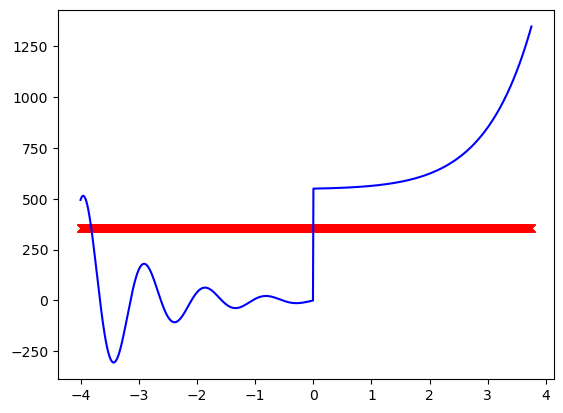

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [15]:
import scipy.io as sio
import numpy as np

for tune_reps in range(5):
    label = "Regr_disc_tanh_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   0.9991158097750219
1   0.9876034271781468
2   0.9632695134943328
3   0.8082847351938275
4   0.7455478456145873


In [14]:
lr_tune[3]

0.008